In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
# from transformers import ViTModel, ViTConfig
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from collections import defaultdict
import itertools
from sklearn.preprocessing import label_binarize
from scipy import interp
import json
from datetime import datetime
import torch.nn.functional as F
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [6]:
# config
CONFIG = {
    'ORIGINAL_DIR': './Original', 
    'SEGMENTED_DIR': './Segmented',
    'BATCH_SIZE': 32,
    'NUM_EPOCHS': 100,
    'LEARNING_RATE': 0.001,
    'PATIENCE': 15,
    'CLASS_NAMES': ['Benign', 'Early', 'Pre', 'Pro'],
    'NUM_CLASSES': 4,
    'IMG_SIZE': 224,
    'RANDOM_STATE': 42
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['RANDOM_STATE'])
np.random.seed(CONFIG['RANDOM_STATE'])

class LeukemiaDataset(Dataset):
    def __init__(self, original_dir, segmented_dir, class_names, split='train', transform=None):
        self.original_dir = original_dir
        self.segmented_dir = segmented_dir
        self.class_names = class_names
        self.transform = transform
        self.split = split
        
        # Load data paths and labels
        self.data = []
        self.labels = []
        
        for class_idx, class_name in enumerate(class_names):
            # Original images
            original_path = os.path.join(original_dir, class_name)
            segmented_path = os.path.join(segmented_dir, class_name)
            
            if os.path.exists(original_path) and os.path.exists(segmented_path):
                original_files = glob.glob(os.path.join(original_path, '*.jpg')) + \
                               glob.glob(os.path.join(original_path, '*.png'))
                
                for orig_file in original_files:
                    filename = os.path.basename(orig_file)
                    seg_file = os.path.join(segmented_path, filename)
                    
                    if os.path.exists(seg_file):
                        self.data.append((orig_file, seg_file))
                        self.labels.append(class_idx)
        
        print(f"{split} dataset: {len(self.data)} samples")
        for i, class_name in enumerate(class_names):
            count = self.labels.count(i)
            print(f"  {class_name}: {count} samples")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        original_path, segmented_path = self.data[idx]
        label = self.labels[idx]
        
        #load the img
        original_img = Image.open(original_path).convert('RGB')
        segmented_img = Image.open(segmented_path).convert('RGB')
        
        if self.transform:
            original_img = self.transform(original_img)
            segmented_img = self.transform(segmented_img)
        
        # channel wise concat
        combined_img = torch.cat([original_img, segmented_img], dim=0)
        
        return combined_img, label, original_path

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_test_transform



In [7]:
# Load transformations
train_transform, val_transform = get_transforms()

# Initialize 
train_dataset = LeukemiaDataset(
    original_dir=CONFIG['ORIGINAL_DIR'],
    segmented_dir=CONFIG['SEGMENTED_DIR'],
    class_names=CONFIG['CLASS_NAMES'],
    split='train',
    transform=train_transform
)


train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)

# Iterate through a few batches
for batch in train_loader:
    images, labels, paths = batch
    print("Batch image shape:", images.shape)  # Should be (BATCH_SIZE, 6, 224, 224)
    print("Batch labels:", labels)
    print("Batch file paths:", paths[:2])  # Print only a couple of paths for brevity
    break  # Just one batch for testing


train dataset: 3256 samples
  Benign: 504 samples
  Early: 985 samples
  Pre: 963 samples
  Pro: 804 samples
Batch image shape: torch.Size([32, 6, 224, 224])
Batch labels: tensor([2, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 1, 3, 2, 3, 3, 2, 1, 0, 2, 1, 3, 3, 1,
        2, 1, 3, 3, 0, 2, 3, 1])
Batch file paths: ('./Original/Pre/WBC-Malignant-Pre-200.jpg', './Original/Early/WBC-Malignant-Early-342.jpg')


In [9]:
# Model 1: U-Net (Low Complexity)
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=6):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        
        # Bottleneck
        bottleneck = self.bottleneck(e4)
        
        # Global pooling and classification
        gap = self.gap(bottleneck)
        gap = gap.view(gap.size(0), -1)
        out = self.classifier(gap)
        
        return out

# Model 2: ResNet (Medium Complexity)
class CustomResNet(nn.Module):
    def __init__(self, num_classes, in_channels=6):
        super(CustomResNet, self).__init__()
        
        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=True)
        
        # Modify first conv layer for 6 channels
        self.backbone.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Modify classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Model 3: VGG (Medium Complexity)
class CustomVGG(nn.Module):
    def __init__(self, num_classes, in_channels=6):
        super(CustomVGG, self).__init__()
        
        # Use VGG19 as backbone
        self.backbone = models.vgg19(pretrained=True)
        
        # Modify first conv layer for 6 channels
        self.backbone.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        
        # Freeze feature extractor
        for param in self.backbone.features.parameters():
            param.requires_grad = False
        
        # Modify classifier
        self.backbone.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Model 4: Vision Transformer (High Complexity)
# class CustomViT(nn.Module):
#     def __init__(self, num_classes, in_channels=6, image_size=224, patch_size=16):
#         super(CustomViT, self).__init__()
        
#         # Convert 6 channels to 3 channels
#         self.channel_adapter = nn.Conv2d(in_channels, 3, kernel_size=1)
        
#         config = ViTConfig(
#             image_size=image_size,
#             patch_size=patch_size,
#             num_channels=3,
#             hidden_size=768,
#             num_hidden_layers=12,
#             num_attention_heads=12,
#             intermediate_size=3072,
#             num_labels=num_classes,
#         )
        
#         self.vit = ViTModel(config)
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.3),
#             nn.Linear(768, 512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(512, num_classes)
#         )
    
#     def forward(self, x):
#         x = self.channel_adapter(x)
#         outputs = self.vit(pixel_values=x)
#         pooled_output = outputs.pooler_output
#         return self.classifier(pooled_output)

import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

class CustomViT(nn.Module):
    def __init__(self, num_classes, in_channels=6):
        super(CustomViT, self).__init__()
        
        # Adapt 6 channels to 3
        self.channel_adapter = nn.Conv2d(in_channels, 3, kernel_size=1)

        # Load pretrained ViT-B-16 weights
        self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        
        # Replace the classification head
        self.vit.heads = nn.Sequential(
            nn.Linear(self.vit.hidden_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.channel_adapter(x)
        return self.vit(x)



# Model 5: EfficientNet (High Complexity)
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes, in_channels=6):
        super(CustomEfficientNet, self).__init__()
        
        # Use EfficientNet-B3
        self.backbone = models.efficientnet_b3(pretrained=True)
        
        # Modify first conv layer for 6 channels
        self.backbone.features[0][0] = nn.Conv2d(in_channels, 40, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
        
        # Modify classifier
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

LEUKEMIA CLASSIFICATION ENSEMBLE TRAINING
Loading datasets...
full dataset: 3256 samples
  Benign: 504 samples
  Early: 985 samples
  Pre: 963 samples
  Pro: 804 samples
train dataset: 3256 samples
  Benign: 504 samples
  Early: 985 samples
  Pre: 963 samples
  Pro: 804 samples
val dataset: 3256 samples
  Benign: 504 samples
  Early: 985 samples
  Pre: 963 samples
  Pro: 804 samples
test dataset: 3256 samples
  Benign: 504 samples
  Early: 985 samples
  Pre: 963 samples
  Pro: 804 samples


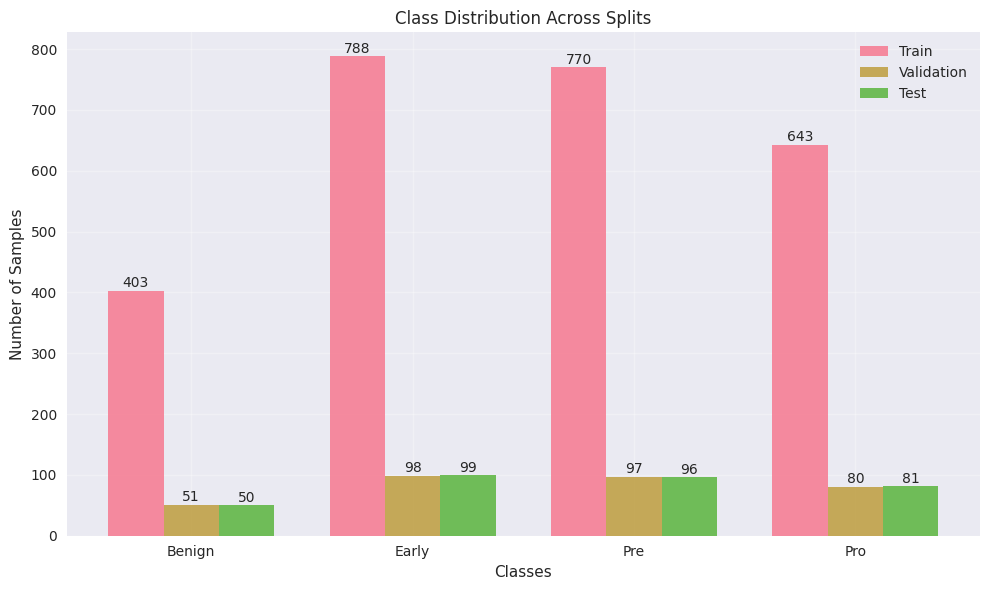


Initializing models...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 114MB/s] 
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 98.8MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 115MB/s]



Model Complexities:
UNet: 19,379,716 total params, 19,379,716 trainable
ResNet50: 26,142,468 total params, 11,550,212 trainable
VGG19: 133,283,588 total params, 113,257,476 trainable
ViT: 86,194,457 total params, 86,194,457 trainable
EfficientNet: 12,798,052 total params, 5,654,910 trainable

TRAINING UNET

Training UNet...


Epoch 1/100: 100%|██████████| 82/82 [00:12<00:00,  6.66it/s, Loss=1.3614, Acc=68.39%]


Epoch 1/100:
Train Loss: 0.8278, Train Acc: 68.39%
Val Loss: 0.5499, Val Acc: 79.14%
LR: 0.002000
--------------------------------------------------


Epoch 2/100: 100%|██████████| 82/82 [00:11<00:00,  7.36it/s, Loss=0.8086, Acc=77.61%]


Epoch 2/100:
Train Loss: 0.5906, Train Acc: 77.61%
Val Loss: 1.0317, Val Acc: 58.59%
LR: 0.001951
--------------------------------------------------


Epoch 3/100: 100%|██████████| 82/82 [00:11<00:00,  7.36it/s, Loss=0.3270, Acc=80.53%]


Epoch 3/100:
Train Loss: 0.5130, Train Acc: 80.53%
Val Loss: 1.0385, Val Acc: 73.01%
LR: 0.001809
--------------------------------------------------


Epoch 4/100: 100%|██████████| 82/82 [00:11<00:00,  7.35it/s, Loss=0.3515, Acc=84.68%]


Epoch 4/100:
Train Loss: 0.4245, Train Acc: 84.68%
Val Loss: 0.8590, Val Acc: 78.22%
LR: 0.001588
--------------------------------------------------


Epoch 5/100: 100%|██████████| 82/82 [00:11<00:00,  7.33it/s, Loss=0.3388, Acc=85.45%]


Epoch 5/100:
Train Loss: 0.4047, Train Acc: 85.45%
Val Loss: 3.0919, Val Acc: 55.52%
LR: 0.001309
--------------------------------------------------


Epoch 6/100: 100%|██████████| 82/82 [00:11<00:00,  7.28it/s, Loss=0.8968, Acc=86.56%]


Epoch 6/100:
Train Loss: 0.3781, Train Acc: 86.56%
Val Loss: 0.5161, Val Acc: 82.52%
LR: 0.001000
--------------------------------------------------


Epoch 7/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.0528, Acc=87.25%]


Epoch 7/100:
Train Loss: 0.3421, Train Acc: 87.25%
Val Loss: 0.3850, Val Acc: 87.12%
LR: 0.000691
--------------------------------------------------


Epoch 8/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2838, Acc=88.86%]


Epoch 8/100:
Train Loss: 0.3168, Train Acc: 88.86%
Val Loss: 0.2072, Val Acc: 93.25%
LR: 0.000412
--------------------------------------------------


Epoch 9/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.5326, Acc=89.25%]


Epoch 9/100:
Train Loss: 0.3009, Train Acc: 89.25%
Val Loss: 0.2859, Val Acc: 89.26%
LR: 0.000191
--------------------------------------------------


Epoch 10/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.3050, Acc=89.48%]


Epoch 10/100:
Train Loss: 0.2804, Train Acc: 89.48%
Val Loss: 0.2658, Val Acc: 91.41%
LR: 0.000049
--------------------------------------------------


Epoch 11/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2692, Acc=84.72%]


Epoch 11/100:
Train Loss: 0.4211, Train Acc: 84.72%
Val Loss: 0.9961, Val Acc: 72.09%
LR: 0.002000
--------------------------------------------------


Epoch 12/100: 100%|██████████| 82/82 [00:11<00:00,  7.30it/s, Loss=0.5867, Acc=85.79%]


Epoch 12/100:
Train Loss: 0.4091, Train Acc: 85.79%
Val Loss: 0.4301, Val Acc: 84.66%
LR: 0.001988
--------------------------------------------------


Epoch 13/100: 100%|██████████| 82/82 [00:11<00:00,  7.27it/s, Loss=0.5753, Acc=85.64%]


Epoch 13/100:
Train Loss: 0.4096, Train Acc: 85.64%
Val Loss: 0.7829, Val Acc: 70.55%
LR: 0.001951
--------------------------------------------------


Epoch 14/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.7101, Acc=86.44%]


Epoch 14/100:
Train Loss: 0.3800, Train Acc: 86.44%
Val Loss: 0.4719, Val Acc: 85.89%
LR: 0.001891
--------------------------------------------------


Epoch 15/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.4904, Acc=88.13%]


Epoch 15/100:
Train Loss: 0.3658, Train Acc: 88.13%
Val Loss: 0.6302, Val Acc: 67.18%
LR: 0.001809
--------------------------------------------------


Epoch 16/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.2651, Acc=87.60%]


Epoch 16/100:
Train Loss: 0.3490, Train Acc: 87.60%
Val Loss: 0.4723, Val Acc: 85.58%
LR: 0.001707
--------------------------------------------------


Epoch 17/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.1281, Acc=87.63%]


Epoch 17/100:
Train Loss: 0.3644, Train Acc: 87.63%
Val Loss: 0.8466, Val Acc: 74.54%
LR: 0.001588
--------------------------------------------------


Epoch 18/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2522, Acc=89.44%]


Epoch 18/100:
Train Loss: 0.3005, Train Acc: 89.44%
Val Loss: 0.8417, Val Acc: 78.53%
LR: 0.001454
--------------------------------------------------


Epoch 19/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.1554, Acc=89.94%]


Epoch 19/100:
Train Loss: 0.3107, Train Acc: 89.94%
Val Loss: 0.2155, Val Acc: 94.48%
LR: 0.001309
--------------------------------------------------


Epoch 20/100: 100%|██████████| 82/82 [00:11<00:00,  7.32it/s, Loss=0.6048, Acc=90.05%]


Epoch 20/100:
Train Loss: 0.3037, Train Acc: 90.05%
Val Loss: 0.3459, Val Acc: 89.57%
LR: 0.001156
--------------------------------------------------


Epoch 21/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.1080, Acc=90.63%]


Epoch 21/100:
Train Loss: 0.2732, Train Acc: 90.63%
Val Loss: 1.0867, Val Acc: 84.97%
LR: 0.001000
--------------------------------------------------


Epoch 22/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.1663, Acc=91.13%]


Epoch 22/100:
Train Loss: 0.2652, Train Acc: 91.13%
Val Loss: 0.2231, Val Acc: 93.56%
LR: 0.000844
--------------------------------------------------


Epoch 23/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2188, Acc=91.63%]


Epoch 23/100:
Train Loss: 0.2429, Train Acc: 91.63%
Val Loss: 0.1980, Val Acc: 94.48%
LR: 0.000691
--------------------------------------------------


Epoch 24/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.3291, Acc=91.90%]


Epoch 24/100:
Train Loss: 0.2362, Train Acc: 91.90%
Val Loss: 0.4431, Val Acc: 87.73%
LR: 0.000546
--------------------------------------------------


Epoch 25/100: 100%|██████████| 82/82 [00:11<00:00,  7.28it/s, Loss=0.4496, Acc=92.32%]


Epoch 25/100:
Train Loss: 0.2296, Train Acc: 92.32%
Val Loss: 0.1721, Val Acc: 96.01%
LR: 0.000412
--------------------------------------------------


Epoch 26/100: 100%|██████████| 82/82 [00:11<00:00,  7.33it/s, Loss=0.3859, Acc=93.01%]


Epoch 26/100:
Train Loss: 0.1963, Train Acc: 93.01%
Val Loss: 0.3948, Val Acc: 90.49%
LR: 0.000293
--------------------------------------------------


Epoch 27/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.4813, Acc=93.55%]


Epoch 27/100:
Train Loss: 0.1912, Train Acc: 93.55%
Val Loss: 0.1807, Val Acc: 95.09%
LR: 0.000191
--------------------------------------------------


Epoch 28/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.0600, Acc=93.74%]


Epoch 28/100:
Train Loss: 0.1838, Train Acc: 93.74%
Val Loss: 0.1551, Val Acc: 96.63%
LR: 0.000109
--------------------------------------------------


Epoch 29/100: 100%|██████████| 82/82 [00:11<00:00,  7.30it/s, Loss=0.0483, Acc=93.36%]


Epoch 29/100:
Train Loss: 0.1867, Train Acc: 93.36%
Val Loss: 0.1666, Val Acc: 96.01%
LR: 0.000049
--------------------------------------------------


Epoch 30/100: 100%|██████████| 82/82 [00:11<00:00,  7.30it/s, Loss=0.0358, Acc=94.43%]


Epoch 30/100:
Train Loss: 0.1728, Train Acc: 94.43%
Val Loss: 0.1633, Val Acc: 96.01%
LR: 0.000012
--------------------------------------------------


Epoch 31/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2013, Acc=89.21%]


Epoch 31/100:
Train Loss: 0.3428, Train Acc: 89.21%
Val Loss: 0.5268, Val Acc: 83.74%
LR: 0.002000
--------------------------------------------------


Epoch 32/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.3058, Acc=89.44%]


Epoch 32/100:
Train Loss: 0.3075, Train Acc: 89.44%
Val Loss: 0.2096, Val Acc: 93.87%
LR: 0.001997
--------------------------------------------------


Epoch 33/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.3764, Acc=90.28%]


Epoch 33/100:
Train Loss: 0.2868, Train Acc: 90.28%
Val Loss: 1.7530, Val Acc: 63.50%
LR: 0.001988
--------------------------------------------------


Epoch 34/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.0760, Acc=90.09%]


Epoch 34/100:
Train Loss: 0.3001, Train Acc: 90.09%
Val Loss: 1.0282, Val Acc: 77.30%
LR: 0.001972
--------------------------------------------------


Epoch 35/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.2978, Acc=92.09%]


Epoch 35/100:
Train Loss: 0.2418, Train Acc: 92.09%
Val Loss: 0.1896, Val Acc: 93.56%
LR: 0.001951
--------------------------------------------------


Epoch 36/100: 100%|██████████| 82/82 [00:11<00:00,  7.33it/s, Loss=0.0665, Acc=91.09%]


Epoch 36/100:
Train Loss: 0.2662, Train Acc: 91.09%
Val Loss: 0.2428, Val Acc: 91.72%
LR: 0.001924
--------------------------------------------------


Epoch 37/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.0262, Acc=91.28%]


Epoch 37/100:
Train Loss: 0.2616, Train Acc: 91.28%
Val Loss: 0.5042, Val Acc: 88.04%
LR: 0.001891
--------------------------------------------------


Epoch 38/100: 100%|██████████| 82/82 [00:11<00:00,  7.30it/s, Loss=0.4940, Acc=91.82%]


Epoch 38/100:
Train Loss: 0.2482, Train Acc: 91.82%
Val Loss: 0.1963, Val Acc: 92.64%
LR: 0.001853
--------------------------------------------------


Epoch 39/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.2758, Acc=92.51%]


Epoch 39/100:
Train Loss: 0.2202, Train Acc: 92.51%
Val Loss: 0.1333, Val Acc: 96.32%
LR: 0.001809
--------------------------------------------------


Epoch 40/100: 100%|██████████| 82/82 [00:11<00:00,  7.30it/s, Loss=0.6193, Acc=92.24%]


Epoch 40/100:
Train Loss: 0.2323, Train Acc: 92.24%
Val Loss: 0.3394, Val Acc: 90.49%
LR: 0.001760
--------------------------------------------------


Epoch 41/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.1295, Acc=92.55%]


Epoch 41/100:
Train Loss: 0.2295, Train Acc: 92.55%
Val Loss: 0.5506, Val Acc: 88.04%
LR: 0.001707
--------------------------------------------------


Epoch 42/100: 100%|██████████| 82/82 [00:11<00:00,  7.29it/s, Loss=0.0186, Acc=93.86%]


Epoch 42/100:
Train Loss: 0.1939, Train Acc: 93.86%
Val Loss: 0.1901, Val Acc: 96.01%
LR: 0.001649
--------------------------------------------------


Epoch 43/100: 100%|██████████| 82/82 [00:11<00:00,  7.31it/s, Loss=0.2440, Acc=93.39%]


Epoch 43/100:
Train Loss: 0.2009, Train Acc: 93.39%
Val Loss: 0.3365, Val Acc: 91.72%
LR: 0.001588
--------------------------------------------------
Early stopping triggered after 43 epochs
Best validation accuracy: 96.6258

TRAINING RESNET50

Training ResNet50...


Epoch 1/100: 100%|██████████| 82/82 [00:05<00:00, 13.89it/s, Loss=0.5600, Acc=80.07%]


Epoch 1/100:
Train Loss: 0.5541, Train Acc: 80.07%
Val Loss: 0.3001, Val Acc: 92.94%
LR: 0.001000
--------------------------------------------------


Epoch 2/100: 100%|██████████| 82/82 [00:05<00:00, 13.79it/s, Loss=0.1037, Acc=89.48%]


Epoch 2/100:
Train Loss: 0.3389, Train Acc: 89.48%
Val Loss: 0.1750, Val Acc: 95.71%
LR: 0.000976
--------------------------------------------------


Epoch 3/100: 100%|██████████| 82/82 [00:05<00:00, 13.91it/s, Loss=1.5622, Acc=89.67%]


Epoch 3/100:
Train Loss: 0.3216, Train Acc: 89.67%
Val Loss: 0.2943, Val Acc: 93.87%
LR: 0.000905
--------------------------------------------------


Epoch 4/100: 100%|██████████| 82/82 [00:05<00:00, 13.84it/s, Loss=0.1654, Acc=91.67%]


Epoch 4/100:
Train Loss: 0.2603, Train Acc: 91.67%
Val Loss: 0.3369, Val Acc: 93.25%
LR: 0.000794
--------------------------------------------------


Epoch 5/100: 100%|██████████| 82/82 [00:05<00:00, 14.11it/s, Loss=0.1649, Acc=93.24%]


Epoch 5/100:
Train Loss: 0.2037, Train Acc: 93.24%
Val Loss: 0.2201, Val Acc: 95.71%
LR: 0.000655
--------------------------------------------------


Epoch 6/100: 100%|██████████| 82/82 [00:05<00:00, 13.77it/s, Loss=0.1626, Acc=94.01%]


Epoch 6/100:
Train Loss: 0.1788, Train Acc: 94.01%
Val Loss: 0.1570, Val Acc: 96.32%
LR: 0.000500
--------------------------------------------------


Epoch 7/100: 100%|██████████| 82/82 [00:06<00:00, 13.59it/s, Loss=0.0649, Acc=94.43%]


Epoch 7/100:
Train Loss: 0.1675, Train Acc: 94.43%
Val Loss: 0.2015, Val Acc: 96.01%
LR: 0.000345
--------------------------------------------------


Epoch 8/100: 100%|██████████| 82/82 [00:05<00:00, 13.91it/s, Loss=0.4690, Acc=94.82%]


Epoch 8/100:
Train Loss: 0.1601, Train Acc: 94.82%
Val Loss: 0.1435, Val Acc: 96.32%
LR: 0.000206
--------------------------------------------------


Epoch 9/100: 100%|██████████| 82/82 [00:05<00:00, 14.26it/s, Loss=0.0462, Acc=94.51%]


Epoch 9/100:
Train Loss: 0.1501, Train Acc: 94.51%
Val Loss: 0.0901, Val Acc: 97.24%
LR: 0.000095
--------------------------------------------------


Epoch 10/100: 100%|██████████| 82/82 [00:05<00:00, 14.07it/s, Loss=0.1212, Acc=95.58%]


Epoch 10/100:
Train Loss: 0.1251, Train Acc: 95.58%
Val Loss: 0.1043, Val Acc: 96.63%
LR: 0.000024
--------------------------------------------------


Epoch 11/100: 100%|██████████| 82/82 [00:05<00:00, 14.21it/s, Loss=0.1936, Acc=92.86%]


Epoch 11/100:
Train Loss: 0.2335, Train Acc: 92.86%
Val Loss: 0.2619, Val Acc: 93.56%
LR: 0.001000
--------------------------------------------------


Epoch 12/100: 100%|██████████| 82/82 [00:05<00:00, 14.22it/s, Loss=0.0559, Acc=93.01%]


Epoch 12/100:
Train Loss: 0.2152, Train Acc: 93.01%
Val Loss: 0.3316, Val Acc: 95.09%
LR: 0.000994
--------------------------------------------------


Epoch 13/100: 100%|██████████| 82/82 [00:05<00:00, 14.17it/s, Loss=0.0141, Acc=93.47%]


Epoch 13/100:
Train Loss: 0.2047, Train Acc: 93.47%
Val Loss: 0.2761, Val Acc: 95.09%
LR: 0.000976
--------------------------------------------------


Epoch 14/100: 100%|██████████| 82/82 [00:05<00:00, 13.98it/s, Loss=0.0638, Acc=93.47%]


Epoch 14/100:
Train Loss: 0.1828, Train Acc: 93.47%
Val Loss: 0.1346, Val Acc: 96.63%
LR: 0.000946
--------------------------------------------------


Epoch 15/100: 100%|██████████| 82/82 [00:05<00:00, 14.19it/s, Loss=0.2289, Acc=94.74%]


Epoch 15/100:
Train Loss: 0.1664, Train Acc: 94.74%
Val Loss: 0.1309, Val Acc: 96.32%
LR: 0.000905
--------------------------------------------------


Epoch 16/100: 100%|██████████| 82/82 [00:05<00:00, 13.99it/s, Loss=0.6128, Acc=93.78%]


Epoch 16/100:
Train Loss: 0.1828, Train Acc: 93.78%
Val Loss: 0.0824, Val Acc: 97.24%
LR: 0.000854
--------------------------------------------------


Epoch 17/100: 100%|██████████| 82/82 [00:05<00:00, 14.16it/s, Loss=1.6355, Acc=94.59%]


Epoch 17/100:
Train Loss: 0.1855, Train Acc: 94.59%
Val Loss: 0.1315, Val Acc: 98.16%
LR: 0.000794
--------------------------------------------------


Epoch 18/100: 100%|██████████| 82/82 [00:05<00:00, 14.14it/s, Loss=0.4130, Acc=94.39%]


Epoch 18/100:
Train Loss: 0.1647, Train Acc: 94.39%
Val Loss: 0.0938, Val Acc: 97.24%
LR: 0.000727
--------------------------------------------------


Epoch 19/100: 100%|██████████| 82/82 [00:05<00:00, 14.02it/s, Loss=0.0136, Acc=94.70%]


Epoch 19/100:
Train Loss: 0.1597, Train Acc: 94.70%
Val Loss: 0.1962, Val Acc: 95.40%
LR: 0.000655
--------------------------------------------------


Epoch 20/100: 100%|██████████| 82/82 [00:05<00:00, 14.30it/s, Loss=0.6230, Acc=94.85%]


Epoch 20/100:
Train Loss: 0.1556, Train Acc: 94.85%
Val Loss: 0.0898, Val Acc: 97.55%
LR: 0.000578
--------------------------------------------------


Epoch 21/100: 100%|██████████| 82/82 [00:05<00:00, 13.90it/s, Loss=0.2462, Acc=95.31%]


Epoch 21/100:
Train Loss: 0.1415, Train Acc: 95.31%
Val Loss: 0.0746, Val Acc: 98.16%
LR: 0.000500
--------------------------------------------------


Epoch 22/100: 100%|██████████| 82/82 [00:05<00:00, 13.91it/s, Loss=0.1697, Acc=95.31%]


Epoch 22/100:
Train Loss: 0.1351, Train Acc: 95.31%
Val Loss: 0.0647, Val Acc: 98.47%
LR: 0.000422
--------------------------------------------------


Epoch 23/100: 100%|██████████| 82/82 [00:05<00:00, 13.97it/s, Loss=0.1583, Acc=96.04%]


Epoch 23/100:
Train Loss: 0.1220, Train Acc: 96.04%
Val Loss: 0.1011, Val Acc: 97.85%
LR: 0.000345
--------------------------------------------------


Epoch 24/100: 100%|██████████| 82/82 [00:05<00:00, 13.69it/s, Loss=0.0317, Acc=96.62%]


Epoch 24/100:
Train Loss: 0.1042, Train Acc: 96.62%
Val Loss: 0.0829, Val Acc: 97.55%
LR: 0.000273
--------------------------------------------------


Epoch 25/100: 100%|██████████| 82/82 [00:06<00:00, 13.62it/s, Loss=0.0090, Acc=96.12%]


Epoch 25/100:
Train Loss: 0.1030, Train Acc: 96.12%
Val Loss: 0.0824, Val Acc: 97.85%
LR: 0.000206
--------------------------------------------------


Epoch 26/100: 100%|██████████| 82/82 [00:06<00:00, 13.56it/s, Loss=0.0113, Acc=96.35%]


Epoch 26/100:
Train Loss: 0.0950, Train Acc: 96.35%
Val Loss: 0.0902, Val Acc: 98.16%
LR: 0.000146
--------------------------------------------------


Epoch 27/100: 100%|██████████| 82/82 [00:05<00:00, 13.81it/s, Loss=0.0773, Acc=96.85%]


Epoch 27/100:
Train Loss: 0.0920, Train Acc: 96.85%
Val Loss: 0.0909, Val Acc: 98.16%
LR: 0.000095
--------------------------------------------------


Epoch 28/100: 100%|██████████| 82/82 [00:06<00:00, 12.06it/s, Loss=0.0039, Acc=97.24%]


Epoch 28/100:
Train Loss: 0.0767, Train Acc: 97.24%
Val Loss: 0.0772, Val Acc: 97.55%
LR: 0.000054
--------------------------------------------------


Epoch 29/100: 100%|██████████| 82/82 [00:05<00:00, 13.99it/s, Loss=0.3632, Acc=96.89%]


Epoch 29/100:
Train Loss: 0.0994, Train Acc: 96.89%
Val Loss: 0.0660, Val Acc: 98.16%
LR: 0.000024
--------------------------------------------------


Epoch 30/100: 100%|██████████| 82/82 [00:05<00:00, 14.16it/s, Loss=0.5151, Acc=96.66%]


Epoch 30/100:
Train Loss: 0.0947, Train Acc: 96.66%
Val Loss: 0.0707, Val Acc: 98.16%
LR: 0.000006
--------------------------------------------------


Epoch 31/100: 100%|██████████| 82/82 [00:05<00:00, 14.31it/s, Loss=0.2033, Acc=94.32%]


Epoch 31/100:
Train Loss: 0.1711, Train Acc: 94.32%
Val Loss: 0.2012, Val Acc: 95.09%
LR: 0.001000
--------------------------------------------------


Epoch 32/100: 100%|██████████| 82/82 [00:05<00:00, 14.05it/s, Loss=0.6824, Acc=94.89%]


Epoch 32/100:
Train Loss: 0.1593, Train Acc: 94.89%
Val Loss: 0.0505, Val Acc: 98.47%
LR: 0.000998
--------------------------------------------------


Epoch 33/100: 100%|██████████| 82/82 [00:07<00:00, 11.52it/s, Loss=0.4439, Acc=94.20%]


Epoch 33/100:
Train Loss: 0.1671, Train Acc: 94.20%
Val Loss: 0.1373, Val Acc: 96.32%
LR: 0.000994
--------------------------------------------------


Epoch 34/100: 100%|██████████| 82/82 [00:06<00:00, 11.97it/s, Loss=0.2079, Acc=93.36%]


Epoch 34/100:
Train Loss: 0.1955, Train Acc: 93.36%
Val Loss: 0.1164, Val Acc: 96.32%
LR: 0.000986
--------------------------------------------------


Epoch 35/100: 100%|██████████| 82/82 [00:06<00:00, 13.52it/s, Loss=0.0846, Acc=94.43%]


Epoch 35/100:
Train Loss: 0.1585, Train Acc: 94.43%
Val Loss: 0.0570, Val Acc: 98.47%
LR: 0.000976
--------------------------------------------------


Epoch 36/100: 100%|██████████| 82/82 [00:06<00:00, 13.30it/s, Loss=0.0954, Acc=94.93%]


Epoch 36/100:
Train Loss: 0.1645, Train Acc: 94.93%
Val Loss: 0.0855, Val Acc: 96.93%
LR: 0.000962
--------------------------------------------------


Epoch 37/100: 100%|██████████| 82/82 [00:05<00:00, 14.32it/s, Loss=0.0216, Acc=95.51%]


Epoch 37/100:
Train Loss: 0.1378, Train Acc: 95.51%
Val Loss: 0.0789, Val Acc: 98.16%
LR: 0.000946
--------------------------------------------------
Early stopping triggered after 37 epochs
Best validation accuracy: 98.4663

TRAINING VGG19

Training VGG19...


Epoch 1/100: 100%|██████████| 82/82 [00:06<00:00, 13.58it/s, Loss=0.6683, Acc=71.43%]


Epoch 1/100:
Train Loss: 0.7519, Train Acc: 71.43%
Val Loss: 0.3736, Val Acc: 87.42%
LR: 0.001000
--------------------------------------------------


Epoch 2/100: 100%|██████████| 82/82 [00:06<00:00, 13.61it/s, Loss=0.3438, Acc=79.45%]


Epoch 2/100:
Train Loss: 0.5556, Train Acc: 79.45%
Val Loss: 0.4497, Val Acc: 88.96%
LR: 0.000976
--------------------------------------------------


Epoch 3/100: 100%|██████████| 82/82 [00:06<00:00, 13.60it/s, Loss=1.8149, Acc=80.84%]


Epoch 3/100:
Train Loss: 0.5316, Train Acc: 80.84%
Val Loss: 0.2793, Val Acc: 91.72%
LR: 0.000905
--------------------------------------------------


Epoch 4/100: 100%|██████████| 82/82 [00:06<00:00, 13.58it/s, Loss=2.0178, Acc=81.68%]


Epoch 4/100:
Train Loss: 0.5217, Train Acc: 81.68%
Val Loss: 0.2620, Val Acc: 92.02%
LR: 0.000794
--------------------------------------------------


Epoch 5/100: 100%|██████████| 82/82 [00:06<00:00, 13.64it/s, Loss=0.0298, Acc=83.79%]


Epoch 5/100:
Train Loss: 0.4512, Train Acc: 83.79%
Val Loss: 0.2685, Val Acc: 93.25%
LR: 0.000655
--------------------------------------------------


Epoch 6/100: 100%|██████████| 82/82 [00:06<00:00, 13.62it/s, Loss=0.5578, Acc=83.45%]


Epoch 6/100:
Train Loss: 0.4462, Train Acc: 83.45%
Val Loss: 0.2483, Val Acc: 93.25%
LR: 0.000500
--------------------------------------------------


Epoch 7/100: 100%|██████████| 82/82 [00:05<00:00, 13.79it/s, Loss=0.2571, Acc=85.25%]


Epoch 7/100:
Train Loss: 0.4008, Train Acc: 85.25%
Val Loss: 0.2255, Val Acc: 95.09%
LR: 0.000345
--------------------------------------------------


Epoch 8/100: 100%|██████████| 82/82 [00:06<00:00, 13.65it/s, Loss=0.4024, Acc=85.91%]


Epoch 8/100:
Train Loss: 0.3915, Train Acc: 85.91%
Val Loss: 0.1836, Val Acc: 94.48%
LR: 0.000206
--------------------------------------------------


Epoch 9/100: 100%|██████████| 82/82 [00:06<00:00, 13.65it/s, Loss=0.2640, Acc=85.45%]


Epoch 9/100:
Train Loss: 0.3853, Train Acc: 85.45%
Val Loss: 0.1731, Val Acc: 94.79%
LR: 0.000095
--------------------------------------------------


Epoch 10/100: 100%|██████████| 82/82 [00:05<00:00, 13.78it/s, Loss=0.4061, Acc=86.87%]


Epoch 10/100:
Train Loss: 0.3643, Train Acc: 86.87%
Val Loss: 0.1688, Val Acc: 94.48%
LR: 0.000024
--------------------------------------------------


Epoch 11/100: 100%|██████████| 82/82 [00:05<00:00, 13.77it/s, Loss=0.7228, Acc=82.72%]


Epoch 11/100:
Train Loss: 0.4583, Train Acc: 82.72%
Val Loss: 0.2021, Val Acc: 94.48%
LR: 0.001000
--------------------------------------------------


Epoch 12/100: 100%|██████████| 82/82 [00:06<00:00, 13.56it/s, Loss=0.4853, Acc=83.60%]


Epoch 12/100:
Train Loss: 0.4994, Train Acc: 83.60%
Val Loss: 0.3603, Val Acc: 89.57%
LR: 0.000994
--------------------------------------------------


Epoch 13/100: 100%|██████████| 82/82 [00:06<00:00, 13.57it/s, Loss=0.3779, Acc=81.80%]


Epoch 13/100:
Train Loss: 0.5015, Train Acc: 81.80%
Val Loss: 0.2253, Val Acc: 93.56%
LR: 0.000976
--------------------------------------------------


Epoch 14/100: 100%|██████████| 82/82 [00:06<00:00, 13.42it/s, Loss=0.1285, Acc=84.60%]


Epoch 14/100:
Train Loss: 0.4652, Train Acc: 84.60%
Val Loss: 0.2584, Val Acc: 94.48%
LR: 0.000946
--------------------------------------------------


Epoch 15/100: 100%|██████████| 82/82 [00:06<00:00, 13.63it/s, Loss=0.7795, Acc=83.53%]


Epoch 15/100:
Train Loss: 0.4704, Train Acc: 83.53%
Val Loss: 0.3153, Val Acc: 94.17%
LR: 0.000905
--------------------------------------------------


Epoch 16/100: 100%|██████████| 82/82 [00:05<00:00, 13.70it/s, Loss=0.2346, Acc=83.99%]


Epoch 16/100:
Train Loss: 0.4433, Train Acc: 83.99%
Val Loss: 0.2357, Val Acc: 90.80%
LR: 0.000854
--------------------------------------------------


Epoch 17/100: 100%|██████████| 82/82 [00:06<00:00, 13.58it/s, Loss=0.1269, Acc=85.14%]


Epoch 17/100:
Train Loss: 0.4226, Train Acc: 85.14%
Val Loss: 0.2128, Val Acc: 93.25%
LR: 0.000794
--------------------------------------------------


Epoch 18/100: 100%|██████████| 82/82 [00:05<00:00, 13.77it/s, Loss=0.5468, Acc=84.41%]


Epoch 18/100:
Train Loss: 0.4486, Train Acc: 84.41%
Val Loss: 0.2472, Val Acc: 92.64%
LR: 0.000727
--------------------------------------------------


Epoch 19/100: 100%|██████████| 82/82 [00:05<00:00, 13.72it/s, Loss=0.2567, Acc=84.91%]


Epoch 19/100:
Train Loss: 0.4349, Train Acc: 84.91%
Val Loss: 0.2028, Val Acc: 92.94%
LR: 0.000655
--------------------------------------------------


Epoch 20/100: 100%|██████████| 82/82 [00:06<00:00, 13.59it/s, Loss=0.2570, Acc=85.71%]


Epoch 20/100:
Train Loss: 0.4012, Train Acc: 85.71%
Val Loss: 0.1794, Val Acc: 93.56%
LR: 0.000578
--------------------------------------------------


Epoch 21/100: 100%|██████████| 82/82 [00:06<00:00, 13.60it/s, Loss=0.2574, Acc=86.25%]


Epoch 21/100:
Train Loss: 0.3951, Train Acc: 86.25%
Val Loss: 0.1970, Val Acc: 92.94%
LR: 0.000500
--------------------------------------------------


Epoch 22/100: 100%|██████████| 82/82 [00:06<00:00, 13.66it/s, Loss=0.3810, Acc=85.94%]


Epoch 22/100:
Train Loss: 0.3972, Train Acc: 85.94%
Val Loss: 0.1853, Val Acc: 92.64%
LR: 0.000422
--------------------------------------------------
Early stopping triggered after 22 epochs
Best validation accuracy: 95.0920

TRAINING VIT

Training ViT...


Epoch 1/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=1.0558, Acc=53.65%]


Epoch 1/100:
Train Loss: 1.0087, Train Acc: 53.65%
Val Loss: 0.7556, Val Acc: 68.10%
LR: 0.000500
--------------------------------------------------


Epoch 2/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5031, Acc=74.19%]


Epoch 2/100:
Train Loss: 0.6400, Train Acc: 74.19%
Val Loss: 0.6047, Val Acc: 76.99%
LR: 0.000488
--------------------------------------------------


Epoch 3/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.7723, Acc=74.81%]


Epoch 3/100:
Train Loss: 0.6111, Train Acc: 74.81%
Val Loss: 0.6127, Val Acc: 76.38%
LR: 0.000452
--------------------------------------------------


Epoch 4/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.4821, Acc=76.46%]


Epoch 4/100:
Train Loss: 0.5888, Train Acc: 76.46%
Val Loss: 0.7079, Val Acc: 73.31%
LR: 0.000397
--------------------------------------------------


Epoch 5/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6634, Acc=76.73%]


Epoch 5/100:
Train Loss: 0.5549, Train Acc: 76.73%
Val Loss: 0.5921, Val Acc: 76.99%
LR: 0.000327
--------------------------------------------------


Epoch 6/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6334, Acc=78.03%]


Epoch 6/100:
Train Loss: 0.5567, Train Acc: 78.03%
Val Loss: 0.6460, Val Acc: 75.15%
LR: 0.000250
--------------------------------------------------


Epoch 7/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5879, Acc=78.38%]


Epoch 7/100:
Train Loss: 0.5163, Train Acc: 78.38%
Val Loss: 0.7397, Val Acc: 73.62%
LR: 0.000173
--------------------------------------------------


Epoch 8/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3905, Acc=79.57%]


Epoch 8/100:
Train Loss: 0.5055, Train Acc: 79.57%
Val Loss: 0.5973, Val Acc: 76.38%
LR: 0.000103
--------------------------------------------------


Epoch 9/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6091, Acc=80.88%]


Epoch 9/100:
Train Loss: 0.4803, Train Acc: 80.88%
Val Loss: 0.6143, Val Acc: 76.69%
LR: 0.000048
--------------------------------------------------


Epoch 10/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.6660, Acc=81.22%]


Epoch 10/100:
Train Loss: 0.4591, Train Acc: 81.22%
Val Loss: 0.5693, Val Acc: 77.91%
LR: 0.000012
--------------------------------------------------


Epoch 11/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6261, Acc=78.00%]


Epoch 11/100:
Train Loss: 0.5407, Train Acc: 78.00%
Val Loss: 0.6468, Val Acc: 76.07%
LR: 0.000500
--------------------------------------------------


Epoch 12/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.9335, Acc=76.92%]


Epoch 12/100:
Train Loss: 0.5716, Train Acc: 76.92%
Val Loss: 0.6112, Val Acc: 77.61%
LR: 0.000497
--------------------------------------------------


Epoch 13/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.7649, Acc=78.57%]


Epoch 13/100:
Train Loss: 0.5526, Train Acc: 78.57%
Val Loss: 0.5625, Val Acc: 78.53%
LR: 0.000488
--------------------------------------------------


Epoch 14/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1985, Acc=79.65%]


Epoch 14/100:
Train Loss: 0.5089, Train Acc: 79.65%
Val Loss: 0.6135, Val Acc: 77.30%
LR: 0.000473
--------------------------------------------------


Epoch 15/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5945, Acc=79.42%]


Epoch 15/100:
Train Loss: 0.5210, Train Acc: 79.42%
Val Loss: 0.5713, Val Acc: 79.14%
LR: 0.000452
--------------------------------------------------


Epoch 16/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3963, Acc=81.76%]


Epoch 16/100:
Train Loss: 0.4639, Train Acc: 81.76%
Val Loss: 0.5093, Val Acc: 79.75%
LR: 0.000427
--------------------------------------------------


Epoch 17/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.2761, Acc=82.26%]


Epoch 17/100:
Train Loss: 0.4521, Train Acc: 82.26%
Val Loss: 0.5441, Val Acc: 79.45%
LR: 0.000397
--------------------------------------------------


Epoch 18/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3920, Acc=82.41%]


Epoch 18/100:
Train Loss: 0.4239, Train Acc: 82.41%
Val Loss: 0.5095, Val Acc: 81.29%
LR: 0.000363
--------------------------------------------------


Epoch 19/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.7183, Acc=83.18%]


Epoch 19/100:
Train Loss: 0.4259, Train Acc: 83.18%
Val Loss: 0.7174, Val Acc: 75.46%
LR: 0.000327
--------------------------------------------------


Epoch 20/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2394, Acc=83.45%]


Epoch 20/100:
Train Loss: 0.4158, Train Acc: 83.45%
Val Loss: 0.6452, Val Acc: 76.07%
LR: 0.000289
--------------------------------------------------


Epoch 21/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.4787, Acc=84.75%]


Epoch 21/100:
Train Loss: 0.3922, Train Acc: 84.75%
Val Loss: 0.6053, Val Acc: 78.22%
LR: 0.000250
--------------------------------------------------


Epoch 22/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.6013, Acc=84.14%]


Epoch 22/100:
Train Loss: 0.4043, Train Acc: 84.14%
Val Loss: 0.3923, Val Acc: 85.89%
LR: 0.000211
--------------------------------------------------


Epoch 23/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2536, Acc=85.25%]


Epoch 23/100:
Train Loss: 0.3809, Train Acc: 85.25%
Val Loss: 0.5180, Val Acc: 81.90%
LR: 0.000173
--------------------------------------------------


Epoch 24/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2800, Acc=86.33%]


Epoch 24/100:
Train Loss: 0.3577, Train Acc: 86.33%
Val Loss: 0.4588, Val Acc: 84.05%
LR: 0.000137
--------------------------------------------------


Epoch 25/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.1848, Acc=85.98%]


Epoch 25/100:
Train Loss: 0.3544, Train Acc: 85.98%
Val Loss: 0.4743, Val Acc: 83.44%
LR: 0.000103
--------------------------------------------------


Epoch 26/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.5871, Acc=86.67%]


Epoch 26/100:
Train Loss: 0.3489, Train Acc: 86.67%
Val Loss: 0.4367, Val Acc: 86.50%
LR: 0.000073
--------------------------------------------------


Epoch 27/100: 100%|██████████| 82/82 [00:20<00:00,  3.97it/s, Loss=0.4533, Acc=87.25%]


Epoch 27/100:
Train Loss: 0.3291, Train Acc: 87.25%
Val Loss: 0.4321, Val Acc: 86.20%
LR: 0.000048
--------------------------------------------------


Epoch 28/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3536, Acc=86.87%]


Epoch 28/100:
Train Loss: 0.3329, Train Acc: 86.87%
Val Loss: 0.5119, Val Acc: 83.13%
LR: 0.000027
--------------------------------------------------


Epoch 29/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2397, Acc=87.29%]


Epoch 29/100:
Train Loss: 0.3254, Train Acc: 87.29%
Val Loss: 0.4941, Val Acc: 83.74%
LR: 0.000012
--------------------------------------------------


Epoch 30/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2056, Acc=87.83%]


Epoch 30/100:
Train Loss: 0.3155, Train Acc: 87.83%
Val Loss: 0.4919, Val Acc: 84.05%
LR: 0.000003
--------------------------------------------------


Epoch 31/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.5977, Acc=81.99%]


Epoch 31/100:
Train Loss: 0.4563, Train Acc: 81.99%
Val Loss: 0.5472, Val Acc: 81.29%
LR: 0.000500
--------------------------------------------------


Epoch 32/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6399, Acc=85.68%]


Epoch 32/100:
Train Loss: 0.3877, Train Acc: 85.68%
Val Loss: 0.6202, Val Acc: 80.37%
LR: 0.000499
--------------------------------------------------


Epoch 33/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1876, Acc=84.79%]


Epoch 33/100:
Train Loss: 0.3986, Train Acc: 84.79%
Val Loss: 0.7756, Val Acc: 70.86%
LR: 0.000497
--------------------------------------------------


Epoch 34/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2122, Acc=84.95%]


Epoch 34/100:
Train Loss: 0.4042, Train Acc: 84.95%
Val Loss: 0.5009, Val Acc: 81.90%
LR: 0.000493
--------------------------------------------------


Epoch 35/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6826, Acc=84.56%]


Epoch 35/100:
Train Loss: 0.3964, Train Acc: 84.56%
Val Loss: 0.3642, Val Acc: 87.42%
LR: 0.000488
--------------------------------------------------


Epoch 36/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2576, Acc=84.22%]


Epoch 36/100:
Train Loss: 0.3978, Train Acc: 84.22%
Val Loss: 0.6119, Val Acc: 79.45%
LR: 0.000481
--------------------------------------------------


Epoch 37/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5576, Acc=85.98%]


Epoch 37/100:
Train Loss: 0.3835, Train Acc: 85.98%
Val Loss: 0.5280, Val Acc: 81.29%
LR: 0.000473
--------------------------------------------------


Epoch 38/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.6336, Acc=86.18%]


Epoch 38/100:
Train Loss: 0.3669, Train Acc: 86.18%
Val Loss: 0.5494, Val Acc: 82.52%
LR: 0.000463
--------------------------------------------------


Epoch 39/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1997, Acc=86.98%]


Epoch 39/100:
Train Loss: 0.3700, Train Acc: 86.98%
Val Loss: 0.4149, Val Acc: 87.12%
LR: 0.000452
--------------------------------------------------


Epoch 40/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=1.2008, Acc=86.21%]


Epoch 40/100:
Train Loss: 0.3590, Train Acc: 86.21%
Val Loss: 0.5552, Val Acc: 83.74%
LR: 0.000440
--------------------------------------------------


Epoch 41/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.6161, Acc=86.44%]


Epoch 41/100:
Train Loss: 0.3673, Train Acc: 86.44%
Val Loss: 0.4577, Val Acc: 84.97%
LR: 0.000427
--------------------------------------------------


Epoch 42/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.2173, Acc=86.75%]


Epoch 42/100:
Train Loss: 0.3469, Train Acc: 86.75%
Val Loss: 0.3304, Val Acc: 91.10%
LR: 0.000412
--------------------------------------------------


Epoch 43/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.5130, Acc=88.13%]


Epoch 43/100:
Train Loss: 0.3301, Train Acc: 88.13%
Val Loss: 0.4506, Val Acc: 86.20%
LR: 0.000397
--------------------------------------------------


Epoch 44/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.2815, Acc=87.98%]


Epoch 44/100:
Train Loss: 0.3191, Train Acc: 87.98%
Val Loss: 0.4451, Val Acc: 85.28%
LR: 0.000381
--------------------------------------------------


Epoch 45/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1369, Acc=87.60%]


Epoch 45/100:
Train Loss: 0.3210, Train Acc: 87.60%
Val Loss: 0.4443, Val Acc: 86.20%
LR: 0.000363
--------------------------------------------------


Epoch 46/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.3723, Acc=89.55%]


Epoch 46/100:
Train Loss: 0.3045, Train Acc: 89.55%
Val Loss: 0.3558, Val Acc: 89.26%
LR: 0.000346
--------------------------------------------------


Epoch 47/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.3337, Acc=89.29%]


Epoch 47/100:
Train Loss: 0.2924, Train Acc: 89.29%
Val Loss: 0.5513, Val Acc: 84.05%
LR: 0.000327
--------------------------------------------------


Epoch 48/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.3651, Acc=88.67%]


Epoch 48/100:
Train Loss: 0.3103, Train Acc: 88.67%
Val Loss: 0.4712, Val Acc: 85.28%
LR: 0.000308
--------------------------------------------------


Epoch 49/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5378, Acc=89.13%]


Epoch 49/100:
Train Loss: 0.2994, Train Acc: 89.13%
Val Loss: 0.4051, Val Acc: 87.73%
LR: 0.000289
--------------------------------------------------


Epoch 50/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1522, Acc=89.94%]


Epoch 50/100:
Train Loss: 0.2715, Train Acc: 89.94%
Val Loss: 0.4719, Val Acc: 86.81%
LR: 0.000270
--------------------------------------------------


Epoch 51/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2005, Acc=90.71%]


Epoch 51/100:
Train Loss: 0.2598, Train Acc: 90.71%
Val Loss: 0.4033, Val Acc: 87.73%
LR: 0.000250
--------------------------------------------------


Epoch 52/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.0672, Acc=90.21%]


Epoch 52/100:
Train Loss: 0.2639, Train Acc: 90.21%
Val Loss: 0.3867, Val Acc: 89.26%
LR: 0.000230
--------------------------------------------------


Epoch 53/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5133, Acc=89.55%]


Epoch 53/100:
Train Loss: 0.2668, Train Acc: 89.55%
Val Loss: 0.4815, Val Acc: 86.81%
LR: 0.000211
--------------------------------------------------


Epoch 54/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.4488, Acc=90.63%]


Epoch 54/100:
Train Loss: 0.2590, Train Acc: 90.63%
Val Loss: 0.4464, Val Acc: 88.04%
LR: 0.000192
--------------------------------------------------


Epoch 55/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.0369, Acc=91.51%]


Epoch 55/100:
Train Loss: 0.2240, Train Acc: 91.51%
Val Loss: 0.3397, Val Acc: 92.94%
LR: 0.000173
--------------------------------------------------


Epoch 56/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1060, Acc=91.28%]


Epoch 56/100:
Train Loss: 0.2311, Train Acc: 91.28%
Val Loss: 0.4194, Val Acc: 90.18%
LR: 0.000154
--------------------------------------------------


Epoch 57/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.4601, Acc=91.17%]


Epoch 57/100:
Train Loss: 0.2461, Train Acc: 91.17%
Val Loss: 0.3582, Val Acc: 92.33%
LR: 0.000137
--------------------------------------------------


Epoch 58/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.8220, Acc=91.36%]


Epoch 58/100:
Train Loss: 0.2329, Train Acc: 91.36%
Val Loss: 0.3356, Val Acc: 92.02%
LR: 0.000119
--------------------------------------------------


Epoch 59/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1486, Acc=92.01%]


Epoch 59/100:
Train Loss: 0.2099, Train Acc: 92.01%
Val Loss: 0.4295, Val Acc: 89.57%
LR: 0.000103
--------------------------------------------------


Epoch 60/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.0512, Acc=92.70%]


Epoch 60/100:
Train Loss: 0.2045, Train Acc: 92.70%
Val Loss: 0.3775, Val Acc: 91.10%
LR: 0.000088
--------------------------------------------------


Epoch 61/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3222, Acc=92.74%]


Epoch 61/100:
Train Loss: 0.1996, Train Acc: 92.74%
Val Loss: 0.3917, Val Acc: 89.88%
LR: 0.000073
--------------------------------------------------


Epoch 62/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2233, Acc=93.43%]


Epoch 62/100:
Train Loss: 0.1881, Train Acc: 93.43%
Val Loss: 0.3758, Val Acc: 91.10%
LR: 0.000060
--------------------------------------------------


Epoch 63/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.1472, Acc=93.09%]


Epoch 63/100:
Train Loss: 0.1849, Train Acc: 93.09%
Val Loss: 0.3280, Val Acc: 92.33%
LR: 0.000048
--------------------------------------------------


Epoch 64/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3948, Acc=93.05%]


Epoch 64/100:
Train Loss: 0.1804, Train Acc: 93.05%
Val Loss: 0.3960, Val Acc: 90.49%
LR: 0.000037
--------------------------------------------------


Epoch 65/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.0255, Acc=93.86%]


Epoch 65/100:
Train Loss: 0.1767, Train Acc: 93.86%
Val Loss: 0.3593, Val Acc: 92.94%
LR: 0.000027
--------------------------------------------------


Epoch 66/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2753, Acc=93.63%]


Epoch 66/100:
Train Loss: 0.1803, Train Acc: 93.63%
Val Loss: 0.3706, Val Acc: 92.64%
LR: 0.000019
--------------------------------------------------


Epoch 67/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1837, Acc=93.55%]


Epoch 67/100:
Train Loss: 0.1781, Train Acc: 93.55%
Val Loss: 0.3695, Val Acc: 92.02%
LR: 0.000012
--------------------------------------------------


Epoch 68/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2763, Acc=94.12%]


Epoch 68/100:
Train Loss: 0.1647, Train Acc: 94.12%
Val Loss: 0.3617, Val Acc: 92.94%
LR: 0.000007
--------------------------------------------------


Epoch 69/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.0890, Acc=94.09%]


Epoch 69/100:
Train Loss: 0.1643, Train Acc: 94.09%
Val Loss: 0.3585, Val Acc: 93.56%
LR: 0.000003
--------------------------------------------------


Epoch 70/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.2200, Acc=93.70%]


Epoch 70/100:
Train Loss: 0.1705, Train Acc: 93.70%
Val Loss: 0.3600, Val Acc: 93.25%
LR: 0.000001
--------------------------------------------------


Epoch 71/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.1483, Acc=88.63%]


Epoch 71/100:
Train Loss: 0.3170, Train Acc: 88.63%
Val Loss: 0.5645, Val Acc: 84.97%
LR: 0.000500
--------------------------------------------------


Epoch 72/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.0365, Acc=89.67%]


Epoch 72/100:
Train Loss: 0.2796, Train Acc: 89.67%
Val Loss: 0.5196, Val Acc: 83.74%
LR: 0.000500
--------------------------------------------------


Epoch 73/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1356, Acc=89.36%]


Epoch 73/100:
Train Loss: 0.2855, Train Acc: 89.36%
Val Loss: 0.3502, Val Acc: 88.34%
LR: 0.000499
--------------------------------------------------


Epoch 74/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3446, Acc=89.94%]


Epoch 74/100:
Train Loss: 0.2732, Train Acc: 89.94%
Val Loss: 0.3147, Val Acc: 89.88%
LR: 0.000498
--------------------------------------------------


Epoch 75/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.3374, Acc=90.55%]


Epoch 75/100:
Train Loss: 0.2666, Train Acc: 90.55%
Val Loss: 0.4442, Val Acc: 88.65%
LR: 0.000497
--------------------------------------------------


Epoch 76/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.1990, Acc=90.71%]


Epoch 76/100:
Train Loss: 0.2645, Train Acc: 90.71%
Val Loss: 0.4290, Val Acc: 88.65%
LR: 0.000495
--------------------------------------------------


Epoch 77/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.3071, Acc=90.98%]


Epoch 77/100:
Train Loss: 0.2677, Train Acc: 90.98%
Val Loss: 0.5022, Val Acc: 85.28%
LR: 0.000493
--------------------------------------------------


Epoch 78/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.3797, Acc=89.29%]


Epoch 78/100:
Train Loss: 0.2845, Train Acc: 89.29%
Val Loss: 0.3109, Val Acc: 90.80%
LR: 0.000491
--------------------------------------------------


Epoch 79/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.5513, Acc=91.17%]


Epoch 79/100:
Train Loss: 0.2513, Train Acc: 91.17%
Val Loss: 0.3638, Val Acc: 90.80%
LR: 0.000488
--------------------------------------------------


Epoch 80/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.4205, Acc=90.44%]


Epoch 80/100:
Train Loss: 0.2550, Train Acc: 90.44%
Val Loss: 0.2999, Val Acc: 92.02%
LR: 0.000485
--------------------------------------------------


Epoch 81/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.1024, Acc=90.98%]


Epoch 81/100:
Train Loss: 0.2494, Train Acc: 90.98%
Val Loss: 0.2825, Val Acc: 92.94%
LR: 0.000481
--------------------------------------------------


Epoch 82/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.2716, Acc=90.44%]


Epoch 82/100:
Train Loss: 0.2526, Train Acc: 90.44%
Val Loss: 0.3827, Val Acc: 90.18%
LR: 0.000477
--------------------------------------------------


Epoch 83/100: 100%|██████████| 82/82 [00:20<00:00,  3.98it/s, Loss=0.5144, Acc=90.98%]


Epoch 83/100:
Train Loss: 0.2430, Train Acc: 90.98%
Val Loss: 0.3443, Val Acc: 91.41%
LR: 0.000473
--------------------------------------------------


Epoch 84/100: 100%|██████████| 82/82 [00:20<00:00,  3.99it/s, Loss=0.1860, Acc=89.75%]


Epoch 84/100:
Train Loss: 0.2653, Train Acc: 89.75%
Val Loss: 0.3438, Val Acc: 92.33%
LR: 0.000468
--------------------------------------------------
Early stopping triggered after 84 epochs
Best validation accuracy: 93.5583

TRAINING EFFICIENTNET

Training EfficientNet...


Epoch 1/100: 100%|██████████| 82/82 [00:05<00:00, 14.11it/s, Loss=0.3716, Acc=71.54%]


Epoch 1/100:
Train Loss: 0.6941, Train Acc: 71.54%
Val Loss: 0.3775, Val Acc: 87.73%
LR: 0.000500
--------------------------------------------------


Epoch 2/100: 100%|██████████| 82/82 [00:05<00:00, 14.12it/s, Loss=0.0772, Acc=85.37%]


Epoch 2/100:
Train Loss: 0.3860, Train Acc: 85.37%
Val Loss: 0.3062, Val Acc: 89.57%
LR: 0.000488
--------------------------------------------------


Epoch 3/100: 100%|██████████| 82/82 [00:05<00:00, 14.24it/s, Loss=0.2589, Acc=89.63%]


Epoch 3/100:
Train Loss: 0.3022, Train Acc: 89.63%
Val Loss: 0.2332, Val Acc: 92.02%
LR: 0.000452
--------------------------------------------------


Epoch 4/100: 100%|██████████| 82/82 [00:05<00:00, 14.33it/s, Loss=0.2967, Acc=90.82%]


Epoch 4/100:
Train Loss: 0.2525, Train Acc: 90.82%
Val Loss: 0.2574, Val Acc: 93.25%
LR: 0.000397
--------------------------------------------------


Epoch 5/100: 100%|██████████| 82/82 [00:05<00:00, 14.37it/s, Loss=0.0693, Acc=90.90%]


Epoch 5/100:
Train Loss: 0.2507, Train Acc: 90.90%
Val Loss: 0.1645, Val Acc: 94.79%
LR: 0.000327
--------------------------------------------------


Epoch 6/100: 100%|██████████| 82/82 [00:05<00:00, 14.48it/s, Loss=0.3829, Acc=90.55%]


Epoch 6/100:
Train Loss: 0.2463, Train Acc: 90.55%
Val Loss: 0.1662, Val Acc: 95.09%
LR: 0.000250
--------------------------------------------------


Epoch 7/100: 100%|██████████| 82/82 [00:05<00:00, 14.18it/s, Loss=0.1812, Acc=91.47%]


Epoch 7/100:
Train Loss: 0.2335, Train Acc: 91.47%
Val Loss: 0.1415, Val Acc: 95.40%
LR: 0.000173
--------------------------------------------------


Epoch 8/100: 100%|██████████| 82/82 [00:05<00:00, 14.26it/s, Loss=0.1018, Acc=92.09%]


Epoch 8/100:
Train Loss: 0.1935, Train Acc: 92.09%
Val Loss: 0.1581, Val Acc: 95.09%
LR: 0.000103
--------------------------------------------------


Epoch 9/100: 100%|██████████| 82/82 [00:05<00:00, 14.34it/s, Loss=0.0772, Acc=92.47%]


Epoch 9/100:
Train Loss: 0.1881, Train Acc: 92.47%
Val Loss: 0.1441, Val Acc: 95.71%
LR: 0.000048
--------------------------------------------------


Epoch 10/100: 100%|██████████| 82/82 [00:05<00:00, 14.21it/s, Loss=0.0758, Acc=93.13%]


Epoch 10/100:
Train Loss: 0.1893, Train Acc: 93.13%
Val Loss: 0.1227, Val Acc: 96.63%
LR: 0.000012
--------------------------------------------------


Epoch 11/100: 100%|██████████| 82/82 [00:05<00:00, 14.26it/s, Loss=0.7930, Acc=93.55%]


Epoch 11/100:
Train Loss: 0.1924, Train Acc: 93.55%
Val Loss: 0.1188, Val Acc: 95.40%
LR: 0.000500
--------------------------------------------------


Epoch 12/100: 100%|██████████| 82/82 [00:05<00:00, 14.13it/s, Loss=0.2477, Acc=92.51%]


Epoch 12/100:
Train Loss: 0.2051, Train Acc: 92.51%
Val Loss: 0.1943, Val Acc: 93.25%
LR: 0.000497
--------------------------------------------------


Epoch 13/100: 100%|██████████| 82/82 [00:05<00:00, 14.14it/s, Loss=0.2395, Acc=91.47%]


Epoch 13/100:
Train Loss: 0.2411, Train Acc: 91.47%
Val Loss: 0.1477, Val Acc: 94.17%
LR: 0.000488
--------------------------------------------------


Epoch 14/100: 100%|██████████| 82/82 [00:06<00:00, 13.20it/s, Loss=0.0239, Acc=92.17%]


Epoch 14/100:
Train Loss: 0.2196, Train Acc: 92.17%
Val Loss: 0.1209, Val Acc: 96.01%
LR: 0.000473
--------------------------------------------------


Epoch 15/100: 100%|██████████| 82/82 [00:05<00:00, 13.96it/s, Loss=0.0532, Acc=93.39%]


Epoch 15/100:
Train Loss: 0.1913, Train Acc: 93.39%
Val Loss: 0.1002, Val Acc: 96.93%
LR: 0.000452
--------------------------------------------------


Epoch 16/100: 100%|██████████| 82/82 [00:05<00:00, 14.25it/s, Loss=0.0246, Acc=92.90%]


Epoch 16/100:
Train Loss: 0.1920, Train Acc: 92.90%
Val Loss: 0.1035, Val Acc: 96.63%
LR: 0.000427
--------------------------------------------------


Epoch 17/100: 100%|██████████| 82/82 [00:05<00:00, 14.18it/s, Loss=0.0168, Acc=93.63%]


Epoch 17/100:
Train Loss: 0.1728, Train Acc: 93.63%
Val Loss: 0.0812, Val Acc: 97.85%
LR: 0.000397
--------------------------------------------------


Epoch 18/100: 100%|██████████| 82/82 [00:05<00:00, 14.26it/s, Loss=0.5136, Acc=93.05%]


Epoch 18/100:
Train Loss: 0.2091, Train Acc: 93.05%
Val Loss: 0.0824, Val Acc: 98.16%
LR: 0.000363
--------------------------------------------------


Epoch 19/100: 100%|██████████| 82/82 [00:05<00:00, 14.43it/s, Loss=0.1900, Acc=93.13%]


Epoch 19/100:
Train Loss: 0.1914, Train Acc: 93.13%
Val Loss: 0.0982, Val Acc: 97.24%
LR: 0.000327
--------------------------------------------------


Epoch 20/100: 100%|██████████| 82/82 [00:05<00:00, 14.45it/s, Loss=0.1958, Acc=94.20%]


Epoch 20/100:
Train Loss: 0.1606, Train Acc: 94.20%
Val Loss: 0.1006, Val Acc: 96.93%
LR: 0.000289
--------------------------------------------------


Epoch 21/100: 100%|██████████| 82/82 [00:05<00:00, 14.26it/s, Loss=0.2042, Acc=93.86%]


Epoch 21/100:
Train Loss: 0.1624, Train Acc: 93.86%
Val Loss: 0.0959, Val Acc: 97.85%
LR: 0.000250
--------------------------------------------------


Epoch 22/100: 100%|██████████| 82/82 [00:05<00:00, 14.32it/s, Loss=0.1994, Acc=94.16%]


Epoch 22/100:
Train Loss: 0.1470, Train Acc: 94.16%
Val Loss: 0.0630, Val Acc: 98.16%
LR: 0.000211
--------------------------------------------------


Epoch 23/100: 100%|██████████| 82/82 [00:05<00:00, 14.36it/s, Loss=0.8793, Acc=94.85%]


Epoch 23/100:
Train Loss: 0.1618, Train Acc: 94.85%
Val Loss: 0.0701, Val Acc: 98.47%
LR: 0.000173
--------------------------------------------------


Epoch 24/100: 100%|██████████| 82/82 [00:05<00:00, 14.40it/s, Loss=0.8143, Acc=95.20%]


Epoch 24/100:
Train Loss: 0.1459, Train Acc: 95.20%
Val Loss: 0.0626, Val Acc: 98.16%
LR: 0.000137
--------------------------------------------------


Epoch 25/100: 100%|██████████| 82/82 [00:05<00:00, 14.30it/s, Loss=0.0352, Acc=94.82%]


Epoch 25/100:
Train Loss: 0.1411, Train Acc: 94.82%
Val Loss: 0.0695, Val Acc: 98.16%
LR: 0.000103
--------------------------------------------------


Epoch 26/100: 100%|██████████| 82/82 [00:05<00:00, 14.36it/s, Loss=0.1880, Acc=95.08%]


Epoch 26/100:
Train Loss: 0.1375, Train Acc: 95.08%
Val Loss: 0.0641, Val Acc: 98.16%
LR: 0.000073
--------------------------------------------------


Epoch 27/100: 100%|██████████| 82/82 [00:05<00:00, 14.17it/s, Loss=0.1283, Acc=94.55%]


Epoch 27/100:
Train Loss: 0.1476, Train Acc: 94.55%
Val Loss: 0.0675, Val Acc: 97.55%
LR: 0.000048
--------------------------------------------------


Epoch 28/100: 100%|██████████| 82/82 [00:05<00:00, 13.93it/s, Loss=0.8107, Acc=95.08%]


Epoch 28/100:
Train Loss: 0.1371, Train Acc: 95.08%
Val Loss: 0.0630, Val Acc: 98.16%
LR: 0.000027
--------------------------------------------------


Epoch 29/100: 100%|██████████| 82/82 [00:05<00:00, 14.23it/s, Loss=0.2598, Acc=95.05%]


Epoch 29/100:
Train Loss: 0.1277, Train Acc: 95.05%
Val Loss: 0.0659, Val Acc: 97.85%
LR: 0.000012
--------------------------------------------------


Epoch 30/100: 100%|██████████| 82/82 [00:05<00:00, 13.84it/s, Loss=0.0336, Acc=95.62%]


Epoch 30/100:
Train Loss: 0.1226, Train Acc: 95.62%
Val Loss: 0.0599, Val Acc: 98.16%
LR: 0.000003
--------------------------------------------------


Epoch 31/100: 100%|██████████| 82/82 [00:05<00:00, 13.82it/s, Loss=0.3054, Acc=93.32%]


Epoch 31/100:
Train Loss: 0.1857, Train Acc: 93.32%
Val Loss: 0.1215, Val Acc: 95.09%
LR: 0.000500
--------------------------------------------------


Epoch 32/100: 100%|██████████| 82/82 [00:05<00:00, 14.27it/s, Loss=0.3327, Acc=94.32%]


Epoch 32/100:
Train Loss: 0.1703, Train Acc: 94.32%
Val Loss: 0.1106, Val Acc: 96.32%
LR: 0.000499
--------------------------------------------------


Epoch 33/100: 100%|██████████| 82/82 [00:05<00:00, 14.28it/s, Loss=0.0061, Acc=93.70%]


Epoch 33/100:
Train Loss: 0.1655, Train Acc: 93.70%
Val Loss: 0.1121, Val Acc: 95.71%
LR: 0.000497
--------------------------------------------------


Epoch 34/100: 100%|██████████| 82/82 [00:05<00:00, 14.06it/s, Loss=0.1585, Acc=93.97%]


Epoch 34/100:
Train Loss: 0.1669, Train Acc: 93.97%
Val Loss: 0.0936, Val Acc: 96.63%
LR: 0.000493
--------------------------------------------------


Epoch 35/100: 100%|██████████| 82/82 [00:05<00:00, 13.70it/s, Loss=0.2823, Acc=94.20%]


Epoch 35/100:
Train Loss: 0.1759, Train Acc: 94.20%
Val Loss: 0.0704, Val Acc: 97.85%
LR: 0.000488
--------------------------------------------------


Epoch 36/100: 100%|██████████| 82/82 [00:05<00:00, 14.22it/s, Loss=0.4504, Acc=94.47%]


Epoch 36/100:
Train Loss: 0.1563, Train Acc: 94.47%
Val Loss: 0.1061, Val Acc: 97.24%
LR: 0.000481
--------------------------------------------------


Epoch 37/100: 100%|██████████| 82/82 [00:05<00:00, 14.09it/s, Loss=0.2037, Acc=94.55%]


Epoch 37/100:
Train Loss: 0.1451, Train Acc: 94.55%
Val Loss: 0.0860, Val Acc: 96.93%
LR: 0.000473
--------------------------------------------------


Epoch 38/100: 100%|██████████| 82/82 [00:05<00:00, 14.14it/s, Loss=0.1161, Acc=94.05%]


Epoch 38/100:
Train Loss: 0.1725, Train Acc: 94.05%
Val Loss: 0.0674, Val Acc: 98.47%
LR: 0.000463
--------------------------------------------------
Early stopping triggered after 38 epochs
Best validation accuracy: 98.4663

TRAINING ENSEMBLE MODEL

Training Ensemble...


Epoch 1/50: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s, Loss=0.0173, Acc=94.66%]


Epoch 1/50:
Train Loss: 0.1417, Train Acc: 94.66%
Val Loss: 0.0881, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 2/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0877, Acc=97.77%]


Epoch 2/50:
Train Loss: 0.0712, Train Acc: 97.77%
Val Loss: 0.0628, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 3/50: 100%|██████████| 82/82 [00:21<00:00,  3.78it/s, Loss=0.0359, Acc=97.58%]


Epoch 3/50:
Train Loss: 0.0758, Train Acc: 97.58%
Val Loss: 0.0627, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 4/50: 100%|██████████| 82/82 [00:21<00:00,  3.79it/s, Loss=0.0386, Acc=97.73%]


Epoch 4/50:
Train Loss: 0.0655, Train Acc: 97.73%
Val Loss: 0.0642, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 5/50: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s, Loss=0.1992, Acc=98.12%]


Epoch 5/50:
Train Loss: 0.0634, Train Acc: 98.12%
Val Loss: 0.0565, Val Acc: 98.77%
LR: 0.000500
--------------------------------------------------


Epoch 6/50: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s, Loss=0.0326, Acc=97.89%]


Epoch 6/50:
Train Loss: 0.0619, Train Acc: 97.89%
Val Loss: 0.0618, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 7/50: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s, Loss=0.1610, Acc=98.00%]


Epoch 7/50:
Train Loss: 0.0647, Train Acc: 98.00%
Val Loss: 0.0425, Val Acc: 99.08%
LR: 0.000500
--------------------------------------------------


Epoch 8/50: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s, Loss=0.0026, Acc=98.23%]


Epoch 8/50:
Train Loss: 0.0573, Train Acc: 98.23%
Val Loss: 0.0521, Val Acc: 98.77%
LR: 0.000500
--------------------------------------------------


Epoch 9/50: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s, Loss=0.1289, Acc=97.81%]


Epoch 9/50:
Train Loss: 0.0646, Train Acc: 97.81%
Val Loss: 0.0645, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 10/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0121, Acc=97.85%]


Epoch 10/50:
Train Loss: 0.0635, Train Acc: 97.85%
Val Loss: 0.0738, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 11/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0440, Acc=98.04%]


Epoch 11/50:
Train Loss: 0.0645, Train Acc: 98.04%
Val Loss: 0.0463, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 12/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0044, Acc=98.04%]


Epoch 12/50:
Train Loss: 0.0647, Train Acc: 98.04%
Val Loss: 0.0324, Val Acc: 99.08%
LR: 0.000500
--------------------------------------------------


Epoch 13/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0016, Acc=98.04%]


Epoch 13/50:
Train Loss: 0.0528, Train Acc: 98.04%
Val Loss: 0.0636, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------


Epoch 14/50: 100%|██████████| 82/82 [00:21<00:00,  3.81it/s, Loss=0.0058, Acc=97.66%]


Epoch 14/50:
Train Loss: 0.0704, Train Acc: 97.66%
Val Loss: 0.0551, Val Acc: 98.47%
LR: 0.000500
--------------------------------------------------
Early stopping triggered after 14 epochs

EVALUATING MODELS

Evaluating UNet...


Evaluating UNet: 100%|██████████| 11/11 [00:00<00:00, 14.20it/s]


UNet Test Accuracy: 0.9755

Evaluating ResNet50...


Evaluating ResNet50: 100%|██████████| 11/11 [00:00<00:00, 19.98it/s]


ResNet50 Test Accuracy: 0.9816

Evaluating VGG19...


Evaluating VGG19: 100%|██████████| 11/11 [00:00<00:00, 13.14it/s]


VGG19 Test Accuracy: 0.9417

Evaluating ViT...


Evaluating ViT: 100%|██████████| 11/11 [00:01<00:00,  9.86it/s]


ViT Test Accuracy: 0.9172

Evaluating EfficientNet...


Evaluating EfficientNet: 100%|██████████| 11/11 [00:00<00:00, 19.81it/s]


EfficientNet Test Accuracy: 0.9693

Evaluating Ensemble...


Evaluating Ensemble: 100%|██████████| 11/11 [00:02<00:00,  4.46it/s]


Ensemble Test Accuracy: 0.9785

GENERATING VISUALIZATIONS


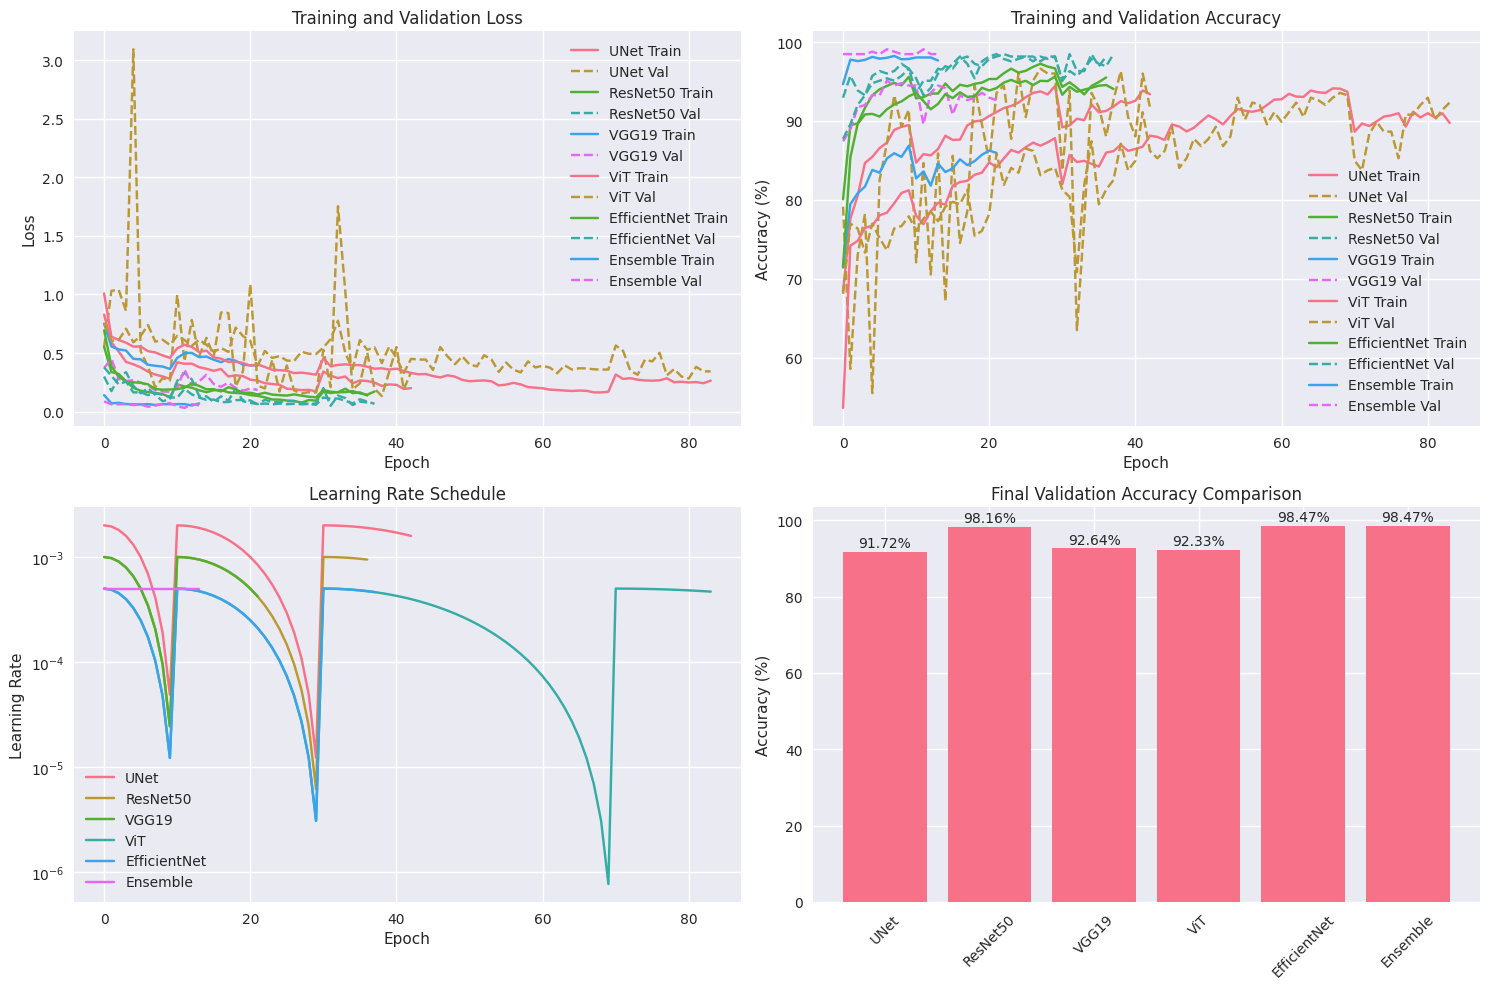

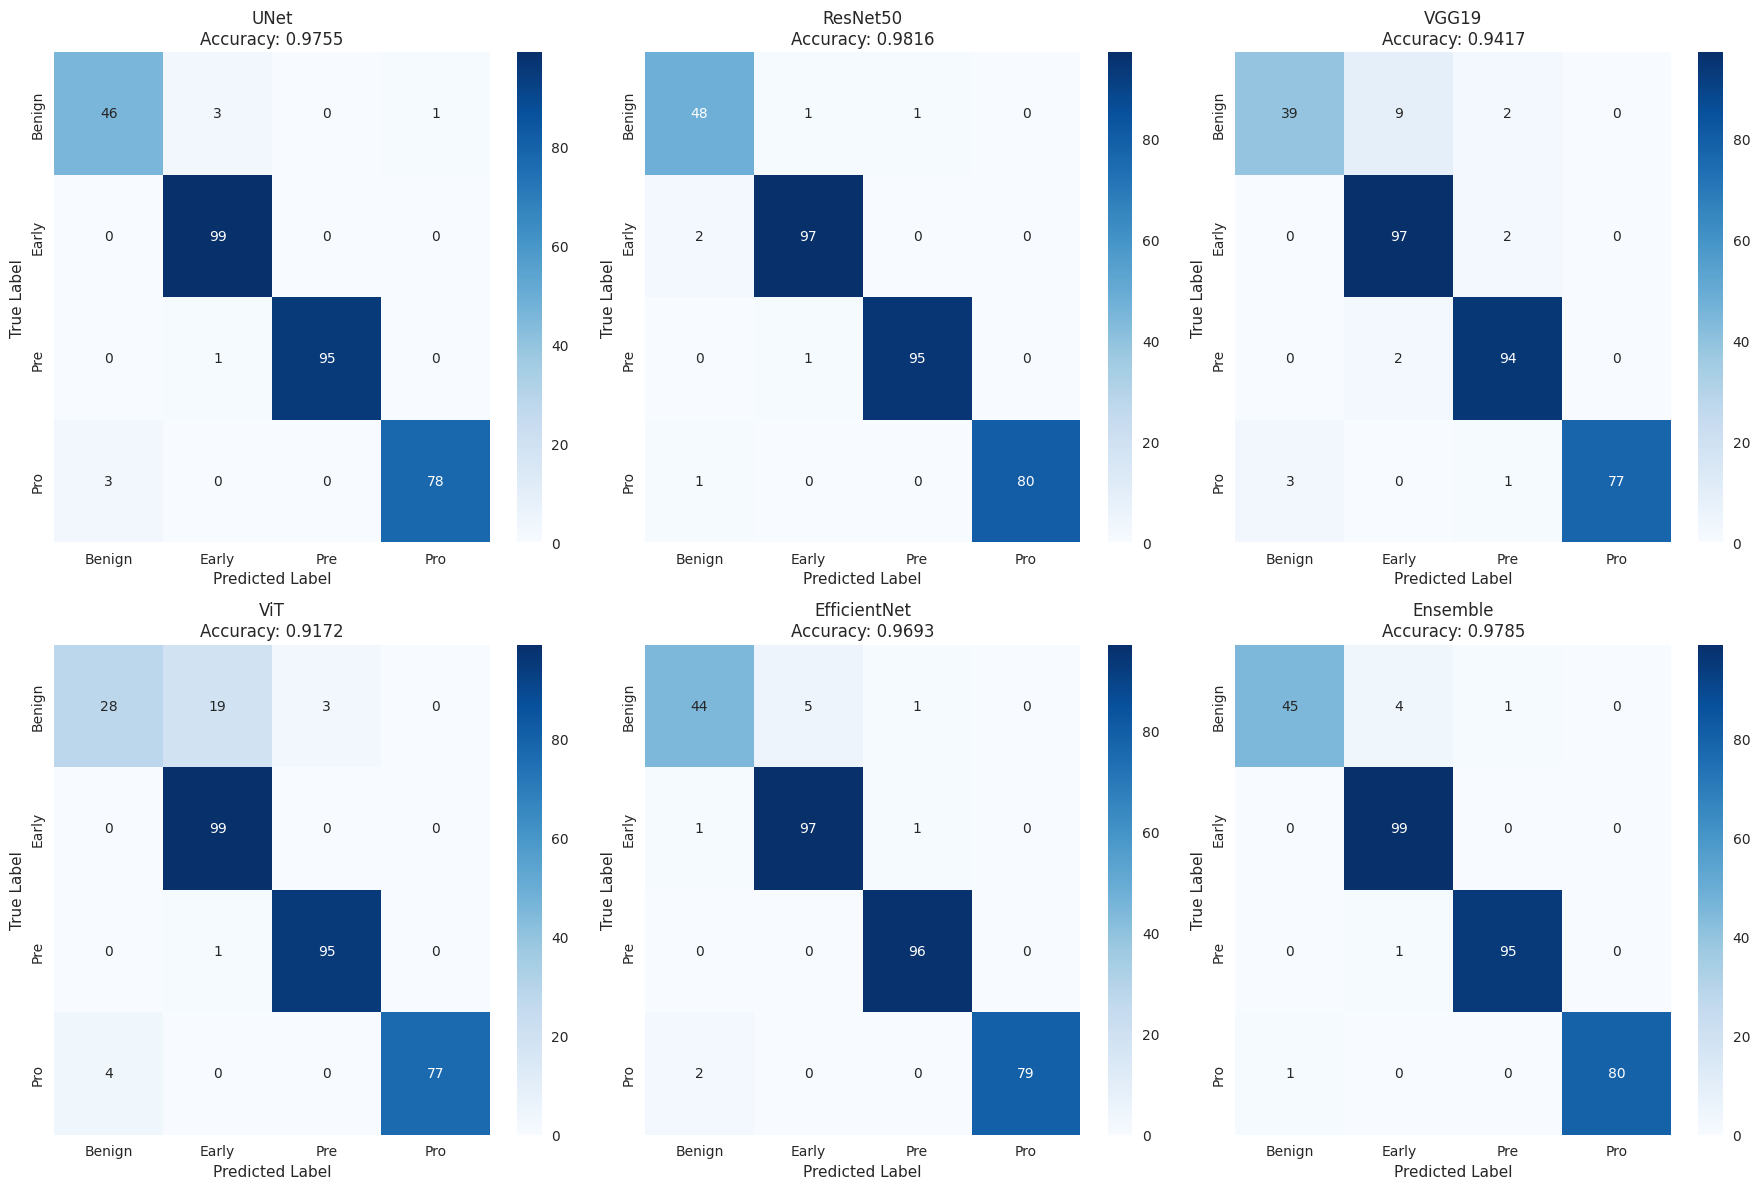

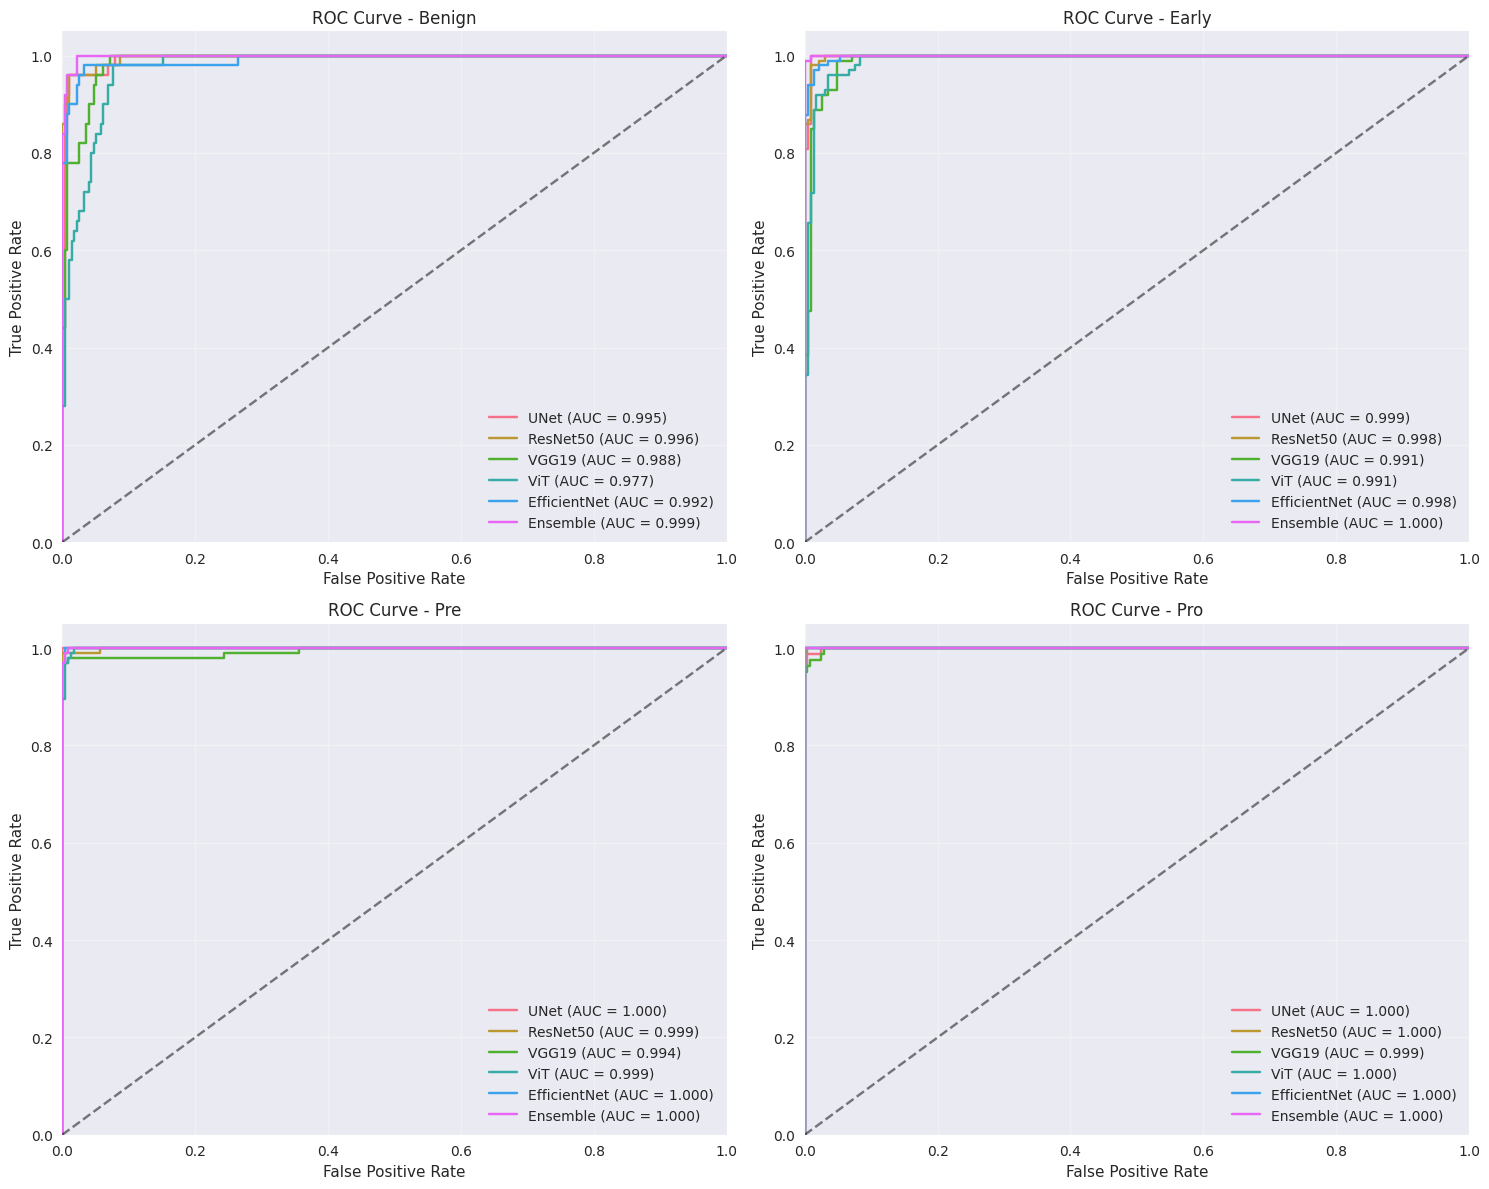

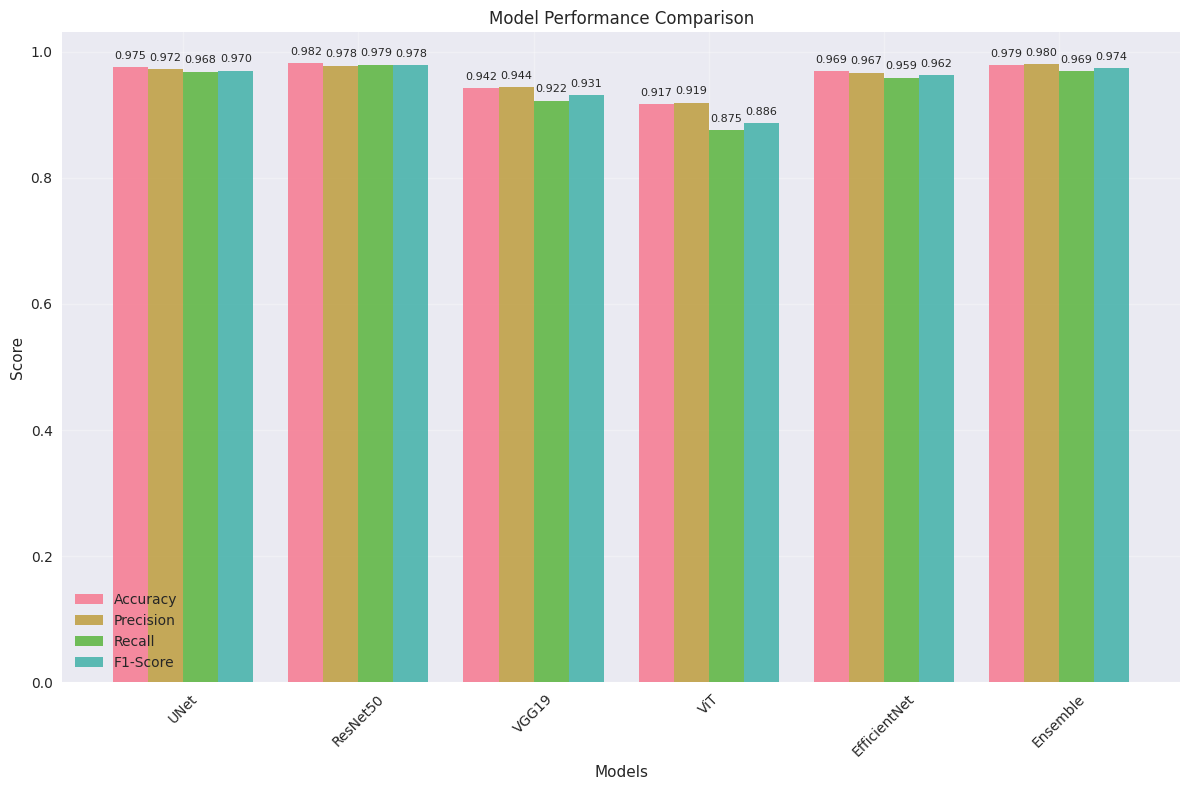

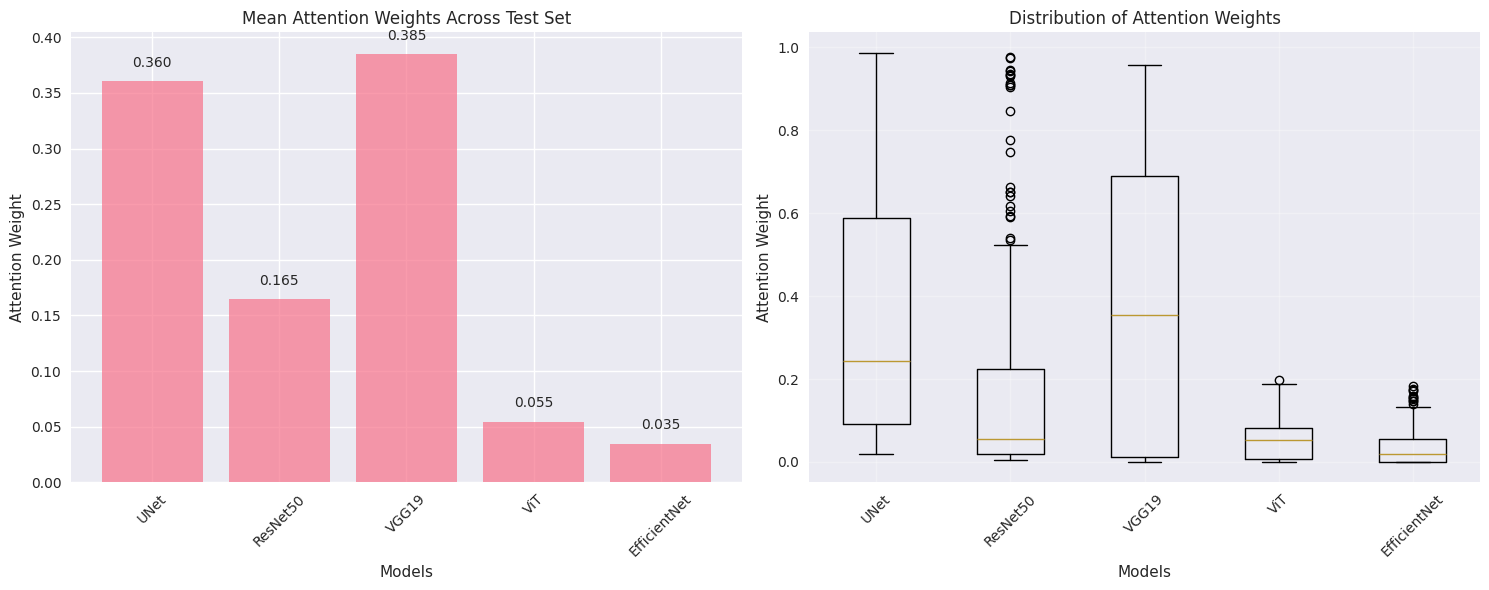

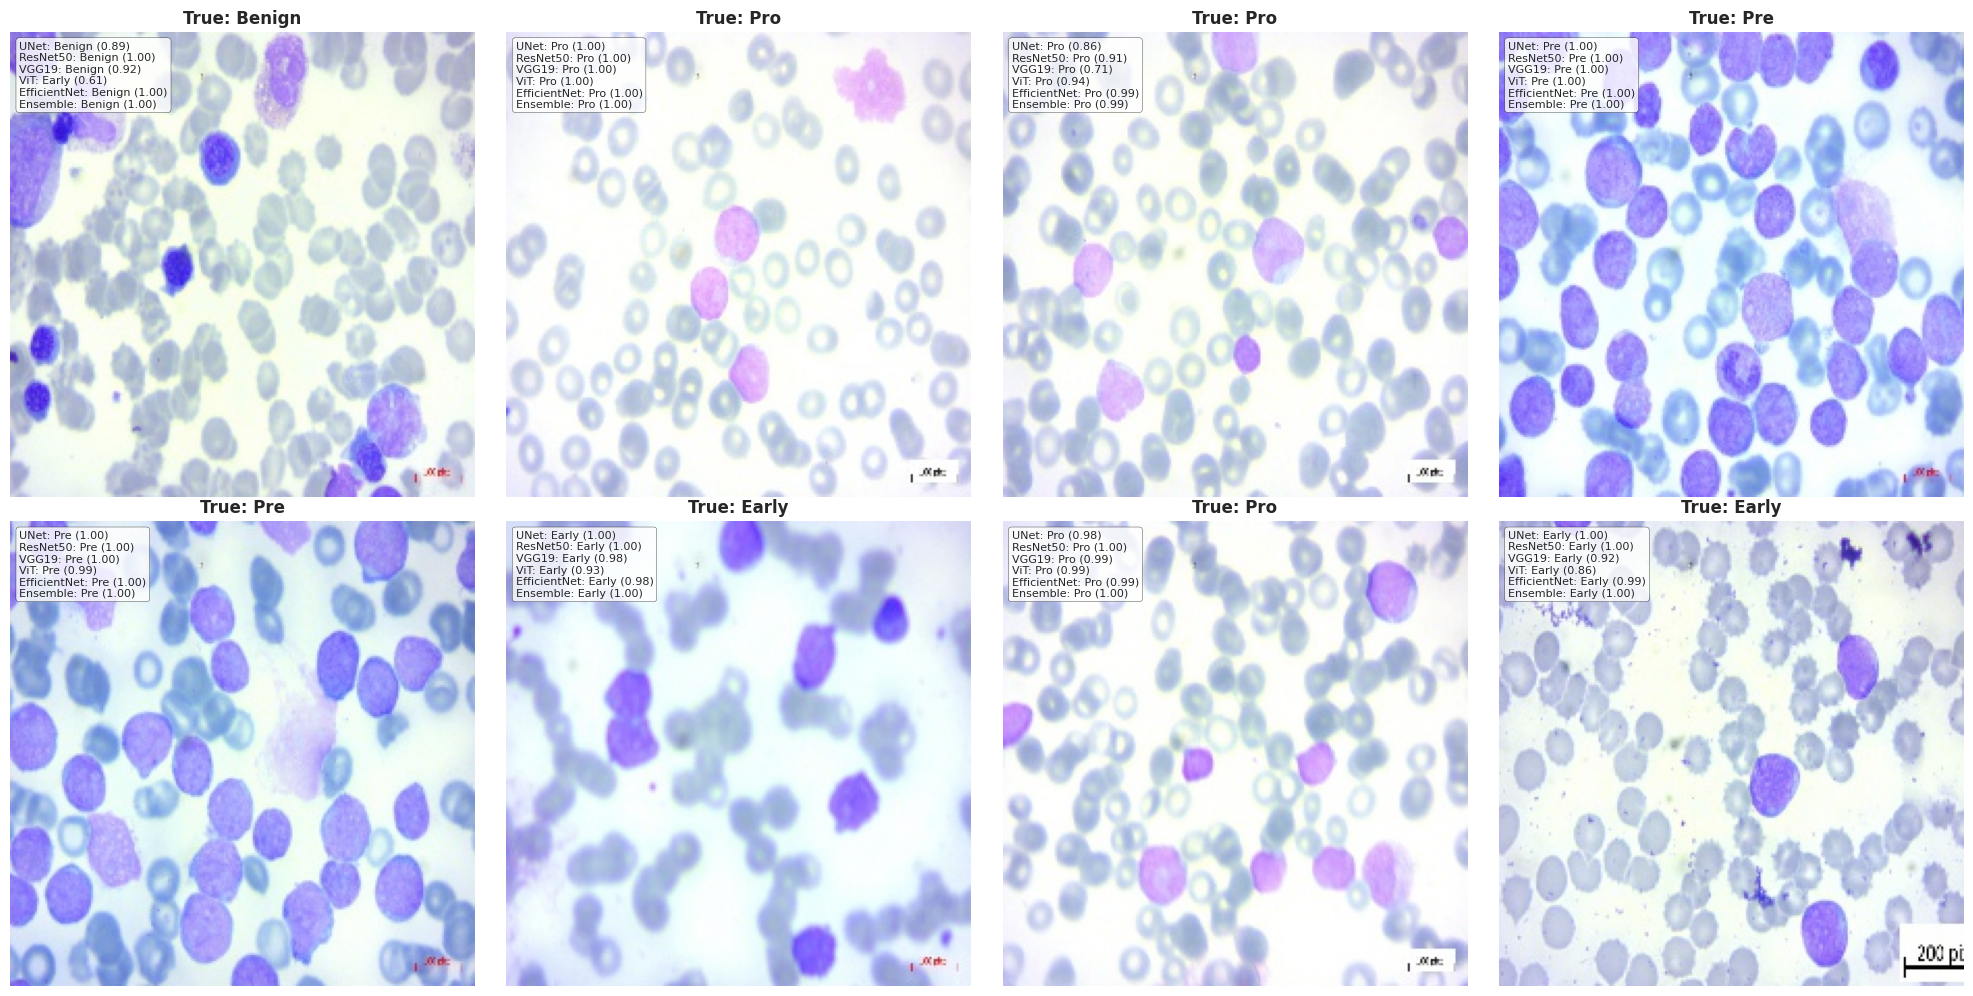

Results summary saved to results/results_summary.json
Detailed report saved to results/detailed_report.txt

FINAL RESULTS SUMMARY

Model Performance (Test Accuracy):
----------------------------------------
ResNet50       : 0.9816
Ensemble       : 0.9785
UNet           : 0.9755
EfficientNet   : 0.9693
VGG19          : 0.9417
ViT            : 0.9172

Best Model: ResNet50 (0.9816)
Ensemble Improvement: +-0.0031 (-0.31%)

All results saved in 'results/' directory
Training completed successfully!


In [10]:
# Ensemble Model
class EnsembleModel(nn.Module):
    def __init__(self, models_dict, num_classes):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleDict(models_dict)
        self.num_models = len(models_dict)
        
        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(num_classes * self.num_models, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        # Attention mechanism for model weighting
        self.attention = nn.Sequential(
            nn.Linear(num_classes * self.num_models, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_models),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        outputs = {}
        model_outputs = []
        
        for name, model in self.models.items():
            output = model(x)
            outputs[name] = output
            model_outputs.append(output)
        
        # Concatenate all outputs
        combined = torch.cat(model_outputs, dim=1)
        
        # Attention weights
        attention_weights = self.attention(combined)
        
        # Weighted combination
        weighted_outputs = []
        for i, output in enumerate(model_outputs):
            weighted_outputs.append(attention_weights[:, i:i+1] * output)
        
        # Final fusion
        ensemble_output = self.fusion(combined)
        
        return ensemble_output, outputs, attention_weights

# Training and validation function
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                      num_epochs, model_name, patience=15):
    
    history = {
        'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
        'lr': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    print(f"\nTraining {model_name}...")
    print("="*50)
    
    for epoch in range(num_epochs):
        #training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (images, labels, _) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            if isinstance(model, EnsembleModel):
                outputs, _, _ = model(images)
            else:
                outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            train_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })
        
        #val
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                if isinstance(model, EnsembleModel):
                    outputs, _, _ = model(images)
                else:
                    outputs = model(images)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Calculate metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100. * correct_train / total_train
        epoch_val_acc = 100. * correct_val / total_val
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['lr'].append(current_lr)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'LR: {current_lr:.6f}')
        print('-' * 50)
        
        # Early stopping and best model saving
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
        
        scheduler.step()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history, best_val_acc

# Evaluation function
def evaluate_model(model, test_loader, class_names, model_name):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            
            if isinstance(model, EnsembleModel):
                outputs, individual_outputs, attention_weights = model(images)
            else:
                outputs = model(images)
            
            probabilities = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    
    results = {
        'accuracy': accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': np.array(all_probabilities),
        'classification_report': classification_report(all_labels, all_predictions, 
                                                    target_names=class_names, output_dict=True)
    }
    
    return results

# Visualization functions
def plot_training_history(histories, save_path='training_history.png'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training and validation loss
    axes[0, 0].set_title('Training and Validation Loss')
    for model_name, history in histories.items():
        axes[0, 0].plot(history['train_loss'], label=f'{model_name} Train')
        axes[0, 0].plot(history['val_loss'], label=f'{model_name} Val', linestyle='--')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training and validation accuracy
    axes[0, 1].set_title('Training and Validation Accuracy')
    for model_name, history in histories.items():
        axes[0, 1].plot(history['train_acc'], label=f'{model_name} Train')
        axes[0, 1].plot(history['val_acc'], label=f'{model_name} Val', linestyle='--')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rates
    axes[1, 0].set_title('Learning Rate Schedule')
    for model_name, history in histories.items():
        axes[1, 0].plot(history['lr'], label=model_name)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].set_yscale('log')
    
    # Plot final validation accuracies
    model_names = list(histories.keys())
    final_val_accs = [history['val_acc'][-1] for history in histories.values()]
    
    axes[1, 1].set_title('Final Validation Accuracy Comparison')
    bars = axes[1, 1].bar(model_names, final_val_accs)
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, final_val_accs):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{acc:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices(results_dict, class_names, save_path='confusion_matrices.png'):
    n_models = len(results_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, (model_name, results) in enumerate(results_dict.items()):
        cm = confusion_matrix(results['labels'], results['predictions'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
        axes[idx].set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.4f}')
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')
    
    # Hide empty subplot
    if n_models < 6:
        axes[n_models].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(results_dict, class_names, save_path='roc_curves.png'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for class_idx, class_name in enumerate(class_names):
        ax = axes[class_idx]
        
        for model_name, results in results_dict.items():
            # Binarize labels for current class
            y_true = label_binarize(results['labels'], classes=range(len(class_names)))[:, class_idx]
            y_scores = results['probabilities'][:, class_idx]
            
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {class_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_model_comparison(results_dict, save_path='model_comparison.png'):
    # Extract metrics
    model_names = list(results_dict.keys())
    accuracies = [results['accuracy'] for results in results_dict.values()]
    
    # Calculate per-class metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for results in results_dict.values():
        report = results['classification_report']
        precision = np.mean([report[class_name]['precision'] for class_name in CONFIG['CLASS_NAMES']])
        recall = np.mean([report[class_name]['recall'] for class_name in CONFIG['CLASS_NAMES']])
        f1 = np.mean([report[class_name]['f1-score'] for class_name in CONFIG['CLASS_NAMES']])
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Create comparison plot
    x = np.arange(len(model_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bars1 = ax.bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
    bars2 = ax.bar(x, precisions, width, label='Precision', alpha=0.8)
    bars3 = ax.bar(x + width, recalls, width, label='Recall', alpha=0.8)
    bars4 = ax.bar(x + 2*width, f1_scores, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    add_value_labels(bars4)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_distribution(train_dataset, val_dataset, test_dataset, class_names, save_path='class_distribution.png'):
    # Count samples per class in each split
    train_counts = [train_dataset.labels.count(i) for i in range(len(class_names))]
    val_counts = [val_dataset.labels.count(i) for i in range(len(class_names))]
    test_counts = [test_dataset.labels.count(i) for i in range(len(class_names))]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars1 = ax.bar(x - width, train_counts, width, label='Train', alpha=0.8)
    bars2 = ax.bar(x, val_counts, width, label='Validation', alpha=0.8)
    bars3 = ax.bar(x + width, test_counts, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution Across Splits')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}', ha='center', va='bottom')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def save_results_summary(results_dict, histories, save_path='results_summary.json'):
    summary = {
        'timestamp': datetime.now().isoformat(),
        'config': CONFIG,
        'results': {}
    }
    
    for model_name, results in results_dict.items():
        summary['results'][model_name] = {
            'accuracy': float(results['accuracy']),
            'classification_report': results['classification_report'],
            'final_val_accuracy': float(histories[model_name]['val_acc'][-1]) if model_name in histories else None
        }
    
    with open(save_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"Results summary saved to {save_path}")

def plot_attention_weights(ensemble_model, test_loader, model_names, save_path='attention_weights.png'):
    """Plot attention weights from ensemble model"""
    ensemble_model.eval()
    all_attention_weights = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            _, _, attention_weights = ensemble_model(images)
            all_attention_weights.append(attention_weights.cpu().numpy())
    
    # Concatenate all attention weights
    all_weights = np.concatenate(all_attention_weights, axis=0)
    mean_weights = np.mean(all_weights, axis=0)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of mean attention weights
    bars = ax1.bar(model_names, mean_weights, alpha=0.7)
    ax1.set_title('Mean Attention Weights Across Test Set')
    ax1.set_ylabel('Attention Weight')
    ax1.set_xlabel('Models')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, weight in zip(bars, mean_weights):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{weight:.3f}', ha='center', va='bottom')
    
    # Box plot of attention weight distributions
    ax2.boxplot(all_weights, labels=model_names)
    ax2.set_title('Distribution of Attention Weights')
    ax2.set_ylabel('Attention Weight')
    ax2.set_xlabel('Models')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_sample_predictions(models_dict, test_loader, class_names, num_samples=8, save_path='sample_predictions.png'):
    """Visualize predictions on sample images"""
    # Get some test samples
    dataiter = iter(test_loader)
    images, labels, paths = next(dataiter)
    
    # Select first num_samples
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    paths = paths[:num_samples]
    
    # Get predictions from all models
    predictions = {}
    confidences = {}
    
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            if isinstance(model, EnsembleModel):
                outputs, _, _ = model(images)
            else:
                outputs = model(images)
            
            probs = torch.softmax(outputs, 1)
            max_probs, preds = torch.max(probs, 1)
            
            predictions[model_name] = preds.cpu().numpy()
            confidences[model_name] = max_probs.cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for idx in range(num_samples):
        # Load and display original image
        img_path = paths[idx]
        img = Image.open(img_path).convert('RGB')
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'True: {class_names[labels[idx]]}', fontsize=12, fontweight='bold')
        
        # Add predictions from all models
        pred_text = []
        for model_name in models_dict.keys():
            pred_class = class_names[predictions[model_name][idx]]
            conf = confidences[model_name][idx]
            color = 'green' if predictions[model_name][idx] == labels[idx] else 'red'
            pred_text.append(f'{model_name}: {pred_class} ({conf:.2f})')
        
        axes[idx].text(0.02, 0.98, '\n'.join(pred_text), transform=axes[idx].transAxes,
                      verticalalignment='top', fontsize=8, 
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def create_detailed_report(results_dict, save_path='detailed_report.txt'):
    """Create a detailed text report"""
    with open(save_path, 'w') as f:
        f.write("LEUKEMIA CLASSIFICATION ENSEMBLE MODEL REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("CONFIGURATION:\n")
        f.write("-" * 20 + "\n")
        for key, value in CONFIG.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")
        
        f.write("MODEL PERFORMANCE SUMMARY:\n")
        f.write("-" * 30 + "\n")
        
        # Sort models by accuracy
        sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        
        for model_name, results in sorted_results:
            f.write(f"\n{model_name.upper()}:\n")
            f.write(f"  Overall Accuracy: {results['accuracy']:.4f}\n")
            
            report = results['classification_report']
            f.write("  Per-class Performance:\n")
            for class_name in CONFIG['CLASS_NAMES']:
                if class_name in report:
                    f.write(f"    {class_name}:\n")
                    f.write(f"      Precision: {report[class_name]['precision']:.4f}\n")
                    f.write(f"      Recall: {report[class_name]['recall']:.4f}\n")
                    f.write(f"      F1-Score: {report[class_name]['f1-score']:.4f}\n")
            
            f.write(f"  Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}\n")
            f.write(f"  Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}\n")
        
        f.write(f"\nBest performing model: {sorted_results[0][0]} with {sorted_results[0][1]['accuracy']:.4f} accuracy\n")
    
    print(f"Detailed report saved to {save_path}")

# Main execution function
def main():
    print("LEUKEMIA CLASSIFICATION ENSEMBLE TRAINING")
    print("=" * 50)
    
    # Create output directory
    os.makedirs('results', exist_ok=True)
    
    # Load and prepare data
    print("Loading datasets...")
    
    # Get transforms
    train_transform, val_test_transform = get_transforms()
    
    # Create full dataset first
    full_dataset = LeukemiaDataset(
        CONFIG['ORIGINAL_DIR'], 
        CONFIG['SEGMENTED_DIR'], 
        CONFIG['CLASS_NAMES'], 
        split='full',
        transform=None
    )
    
    # Split data (80% train, 10% val, 10% test)
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    # Create indices for stratified split
    labels = np.array(full_dataset.labels)
    train_indices, temp_indices = train_test_split(
        range(len(full_dataset)), 
        test_size=0.2, 
        stratify=labels, 
        random_state=CONFIG['RANDOM_STATE']
    )
    
    val_indices, test_indices = train_test_split(
        temp_indices, 
        test_size=0.5, 
        stratify=labels[temp_indices], 
        random_state=CONFIG['RANDOM_STATE']
    )
    
    # Create separate datasets for each split
    train_data = [(full_dataset.data[i], full_dataset.labels[i]) for i in train_indices]
    val_data = [(full_dataset.data[i], full_dataset.labels[i]) for i in val_indices]
    test_data = [(full_dataset.data[i], full_dataset.labels[i]) for i in test_indices]
    
    # Create dataset objects
    train_dataset = LeukemiaDataset(CONFIG['ORIGINAL_DIR'], CONFIG['SEGMENTED_DIR'], 
                                   CONFIG['CLASS_NAMES'], split='train', transform=train_transform)
    train_dataset.data = [item[0] for item in train_data]
    train_dataset.labels = [item[1] for item in train_data]
    
    val_dataset = LeukemiaDataset(CONFIG['ORIGINAL_DIR'], CONFIG['SEGMENTED_DIR'], 
                                 CONFIG['CLASS_NAMES'], split='val', transform=val_test_transform)
    val_dataset.data = [item[0] for item in val_data]
    val_dataset.labels = [item[1] for item in val_data]
    
    test_dataset = LeukemiaDataset(CONFIG['ORIGINAL_DIR'], CONFIG['SEGMENTED_DIR'], 
                                  CONFIG['CLASS_NAMES'], split='test', transform=val_test_transform)
    test_dataset.data = [item[0] for item in test_data]
    test_dataset.labels = [item[1] for item in test_data]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], 
                            shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], 
                          shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], 
                           shuffle=False, num_workers=4, pin_memory=True)
    
    # Plot class distribution
    plot_class_distribution(train_dataset, val_dataset, test_dataset, 
                          CONFIG['CLASS_NAMES'], 'results/class_distribution.png')
    
    # Initialize models
    print("\nInitializing models...")
    models = {
        'UNet': UNet(CONFIG['NUM_CLASSES']).to(device),
        'ResNet50': CustomResNet(CONFIG['NUM_CLASSES']).to(device),
        'VGG19': CustomVGG(CONFIG['NUM_CLASSES']).to(device),
        'ViT': CustomViT(CONFIG['NUM_CLASSES']).to(device),
        'EfficientNet': CustomEfficientNet(CONFIG['NUM_CLASSES']).to(device)
    }
    
    # Print model complexities
    print("\nModel Complexities:")
    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"{name}: {total_params:,} total params, {trainable_params:,} trainable")
    
    # Train individual models
    trained_models = {}
    histories = {}
    
    criterion = nn.CrossEntropyLoss()
    
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"TRAINING {model_name.upper()}")
        print(f"{'='*60}")
        
        # Different learning rates for different model complexities
        if model_name in ['UNet']:
            lr = CONFIG['LEARNING_RATE'] * 2  # Higher LR for simpler models
        elif model_name in ['ViT', 'EfficientNet']:
            lr = CONFIG['LEARNING_RATE'] / 2  # Lower LR for complex models
        else:
            lr = CONFIG['LEARNING_RATE']
        
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        
        trained_model, history, best_val_acc = train_and_validate(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            CONFIG['NUM_EPOCHS'], model_name, CONFIG['PATIENCE']
        )
        
        trained_models[model_name] = trained_model
        histories[model_name] = history
        
        # Save individual model
        torch.save(trained_model.state_dict(), f'results/{model_name.lower()}_model.pth')
        print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    # Create and train ensemble model
    print(f"\n{'='*60}")
    print("TRAINING ENSEMBLE MODEL")
    print(f"{'='*60}")
    
    ensemble_model = EnsembleModel(trained_models, CONFIG['NUM_CLASSES']).to(device)
    
    # Freeze individual model parameters and only train fusion layers
    for model in ensemble_model.models.values():
        for param in model.parameters():
            param.requires_grad = False
    
    optimizer_ensemble = optim.Adam(
        list(ensemble_model.fusion.parameters()) + list(ensemble_model.attention.parameters()),
        lr=CONFIG['LEARNING_RATE'] / 2
    )
    scheduler_ensemble = optim.lr_scheduler.StepLR(optimizer_ensemble, step_size=15, gamma=0.5)
    
    ensemble_model, ensemble_history, ensemble_best_acc = train_and_validate(
        ensemble_model, train_loader, val_loader, criterion, 
        optimizer_ensemble, scheduler_ensemble, CONFIG['NUM_EPOCHS'] // 2, 
        "Ensemble", CONFIG['PATIENCE'] // 2
    )
    
    trained_models['Ensemble'] = ensemble_model
    histories['Ensemble'] = ensemble_history
    
    # Save ensemble model
    torch.save(ensemble_model.state_dict(), 'results/ensemble_model.pth')
    
    # Evaluate all models
    print(f"\n{'='*60}")
    print("EVALUATING MODELS")
    print(f"{'='*60}")
    
    results_dict = {}
    
    for model_name, model in trained_models.items():
        print(f"\nEvaluating {model_name}...")
        results = evaluate_model(model, test_loader, CONFIG['CLASS_NAMES'], model_name)
        results_dict[model_name] = results
        
        print(f"{model_name} Test Accuracy: {results['accuracy']:.4f}")
    
    # Generate all visualizations
    print(f"\n{'='*60}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'='*60}")
    
    # Training history plots
    plot_training_history(histories, 'results/training_history.png')
    
    # Confusion matrices
    plot_confusion_matrices(results_dict, CONFIG['CLASS_NAMES'], 'results/confusion_matrices.png')
    
    # ROC curves
    plot_roc_curves(results_dict, CONFIG['CLASS_NAMES'], 'results/roc_curves.png')
    
    # Model comparison
    plot_model_comparison(results_dict, 'results/model_comparison.png')
    
    # Attention weights (if ensemble model)
    if 'Ensemble' in trained_models:
        model_names = [name for name in trained_models.keys() if name != 'Ensemble']
        plot_attention_weights(trained_models['Ensemble'], test_loader, 
                             model_names, 'results/attention_weights.png')
    
    # Sample predictions
    plot_sample_predictions(trained_models, test_loader, CONFIG['CLASS_NAMES'], 
                          num_samples=8, save_path='results/sample_predictions.png')
    
    # Save results
    save_results_summary(results_dict, histories, 'results/results_summary.json')
    create_detailed_report(results_dict, 'results/detailed_report.txt')
    
    # Print final summary
    print(f"\n{'='*80}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*80}")
    
    print("\nModel Performance (Test Accuracy):")
    print("-" * 40)
    sorted_results = sorted(results_dict.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    for model_name, results in sorted_results:
        print(f"{model_name:15}: {results['accuracy']:.4f}")
    
    print(f"\nBest Model: {sorted_results[0][0]} ({sorted_results[0][1]['accuracy']:.4f})")
    
    if 'Ensemble' in results_dict:
        ensemble_acc = results_dict['Ensemble']['accuracy']
        individual_best = max([results['accuracy'] for name, results in results_dict.items() 
                              if name != 'Ensemble'])
        improvement = ensemble_acc - individual_best
        print(f"Ensemble Improvement: +{improvement:.4f} ({improvement/individual_best*100:.2f}%)")
    
    print(f"\nAll results saved in 'results/' directory")
    print("Training completed successfully!")

if __name__ == "__main__":
    main()